# Neural Network Track Extrapolator Analysis

**Comprehensive analysis notebook for all experiments**

This notebook analyzes results from the neural network track extrapolation experiments:

1. **Architecture Comparison** - MLP vs PINN vs RK_PINN across sizes
2. **Physics Loss Ablation** - Effect of λ_PDE on training and accuracy
3. **Momentum Range Studies** - Performance across momentum spectrum
4. **Timing Benchmarks** - NN inference speed vs C++ extrapolators
5. **Learning Dynamics** - Loss curves and convergence analysis
6. **Generalization Tests** - Out-of-distribution performance

---

**Author:** G. Scriven  
**Date:** January 2026  
**Project:** LHCb Track Extrapolation with Neural Networks

In [38]:
# =============================================================================
# Setup and Imports
# =============================================================================

import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Project paths
PROJECT_ROOT = Path('.').resolve().parent
MODELS_DIR = PROJECT_ROOT / 'models'
TRAINED_MODELS_DIR = PROJECT_ROOT / 'trained_models'
DATA_DIR = PROJECT_ROOT / 'data_generation' / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'
PLOTS_DIR = Path('./plots')
PLOTS_DIR.mkdir(exist_ok=True)

sys.path.insert(0, str(MODELS_DIR))
sys.path.insert(0, str(PROJECT_ROOT / 'analysis'))

print(f"Project root: {PROJECT_ROOT}")
print(f"Trained models: {TRAINED_MODELS_DIR}")
print(f"Data directory: {DATA_DIR}")

Project root: /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation
Trained models: /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/trained_models
Data directory: /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/data_generation/data


In [39]:
# =============================================================================
# Load All Trained Models and Results
# =============================================================================

def load_all_results() -> pd.DataFrame:
    """Load results from all trained models into a DataFrame."""
    results = []
    
    for model_dir in TRAINED_MODELS_DIR.iterdir():
        if not model_dir.is_dir():
            continue
        
        history_file = model_dir / 'history.json'
        config_file = model_dir / 'config.json'
        
        if not history_file.exists():
            continue
        
        with open(history_file) as f:
            history = json.load(f)
        
        config = {}
        if config_file.exists():
            with open(config_file) as f:
                config = json.load(f)
        
        # Parse model type and size from name
        name = model_dir.name
        if name.startswith('mlp_'):
            model_type = 'MLP'
        elif name.startswith('pinn_'):
            model_type = 'PINN'
        elif name.startswith('rkpinn_'):
            model_type = 'RK_PINN'
        else:
            model_type = 'Unknown'
        
        # Determine size/variant
        size = 'medium'  # default
        for s in ['tiny', 'small', 'medium', 'wide']:
            if s in name:
                size = s
                break
        
        # Determine category
        if 'low_p' in name:
            category = 'momentum_low'
        elif 'mid_p' in name:
            category = 'momentum_mid'
        elif 'high_p' in name:
            category = 'momentum_high'
        elif 'data_only' in name:
            category = 'ablation_data_only'
        elif 'pde_weak' in name:
            category = 'ablation_weak'
        elif 'pde_strong' in name:
            category = 'ablation_strong'
        elif 'pde_dominant' in name:
            category = 'ablation_dominant'
        else:
            category = 'core'
        
        # Handle different history formats
        # New format: {'train': [{loss:...}, ...], 'val': [{loss:...}, ...]}
        # Old format: {'train_loss': [...], 'val_loss': [...]}
        if 'train' in history and isinstance(history['train'], list) and len(history['train']) > 0:
            # New format
            train_losses = [epoch.get('loss', epoch.get('data_loss', 0)) for epoch in history['train']]
            val_losses = [epoch.get('loss', epoch.get('data_loss', 0)) for epoch in history.get('val', [])]
            # Convert history to standard format for later use
            history_standardized = {
                'train_loss': train_losses,
                'val_loss': val_losses
            }
        else:
            # Old format or empty
            train_losses = history.get('train_loss', [])
            val_losses = history.get('val_loss', [])
            history_standardized = history
        
        # Compute parameter count from hidden_dims if not available
        n_params = config.get('n_parameters', 0)
        if n_params == 0 and 'hidden_dims' in config:
            hidden_dims = config['hidden_dims']
            # Compute: input(6) -> hidden[0] -> ... -> output(4)
            dims = [6] + hidden_dims + [4]
            n_params = sum(dims[i] * dims[i+1] + dims[i+1] for i in range(len(dims)-1))
        
        result = {
            'name': name,
            'model_type': model_type,
            'size': size,
            'category': category,
            'hidden_dims': str(config.get('hidden_dims', 'N/A')),
            'n_params': n_params,
            'lambda_pde': config.get('lambda_pde', 0.0),
            'lambda_ic': config.get('lambda_ic', 0.0),
            'epochs_trained': len(train_losses),
            'final_train_loss': train_losses[-1] if train_losses else None,
            'final_val_loss': val_losses[-1] if val_losses else None,
            'best_val_loss': min(val_losses) if val_losses else float('inf'),
            'training_time_hrs': config.get('training_time_seconds', 0) / 3600,
        }
        
        # Store full history for later analysis
        result['_history'] = history_standardized
        results.append(result)
    
    df = pd.DataFrame(results)
    return df.sort_values('best_val_loss')

# Load results
try:
    results_df = load_all_results()
    print(f"Loaded {len(results_df)} trained models")
    # Show key columns, filter for valid results
    valid_df = results_df[results_df['best_val_loss'] < float('inf')]
    print(f"Models with valid results: {len(valid_df)}")
    display(valid_df[['name', 'model_type', 'size', 'category', 'n_params', 'best_val_loss', 'epochs_trained']].head(20))
except Exception as e:
    import traceback
    print(f"Error loading models: {e}")
    traceback.print_exc()
    results_df = pd.DataFrame()

Loaded 43 trained models
Models with valid results: 43


,name,model_type,size,category,n_params,best_val_loss,epochs_trained
34,mlp_large_v1,MLP,medium,core,398596,0.000445,10
10,mlp_medium,MLP,medium,core,100996,0.000583,10
13,rkpinn_medium_data_only,RK_PINN,medium,ablation_data_only,100996,0.000671,10
19,mlp_wide,MLP,wide,core,430980,0.000951,10
33,mlp_medium_v1,MLP,medium,core,100996,0.001015,10
30,mlp_wide_v1,MLP,wide,core,430980,0.001172,10
23,rkpinn_medium_pde_weak,RK_PINN,medium,ablation_weak,100996,0.001307,10
9,mlp_small,MLP,small,core,17924,0.001339,10
32,mlp_balanced_v1,MLP,medium,core,57316,0.002088,10
31,mlp_wide_shallow_v1,MLP,wide,core,35204,0.002214,10


---

# 1. Architecture Comparison

**Objective:** Compare MLP, PINN, and RK_PINN architectures across different sizes.

**Key Questions:**
- Which architecture achieves lowest error?
- How does performance scale with model size?
- Is there a clear Pareto frontier (accuracy vs parameters)?

Core experiments found:
             name model_type  n_params  best_val_loss
10     mlp_medium        MLP    100996       0.000583
19       mlp_wide        MLP    430980       0.000951
9       mlp_small        MLP     17924       0.001339
28    rkpinn_wide    RK_PINN    430980       0.002505
14     pinn_small       PINN     17924       0.002996
16       mlp_tiny        MLP      4868       0.003086
12      pinn_tiny       PINN      4868       0.003622
21   rkpinn_small    RK_PINN     17924       0.003726
20  rkpinn_medium    RK_PINN    100996       0.003906
27      pinn_wide       PINN    430980       0.004236
26    rkpinn_tiny    RK_PINN      4868       0.004911
1     pinn_medium       PINN    100996       0.006982


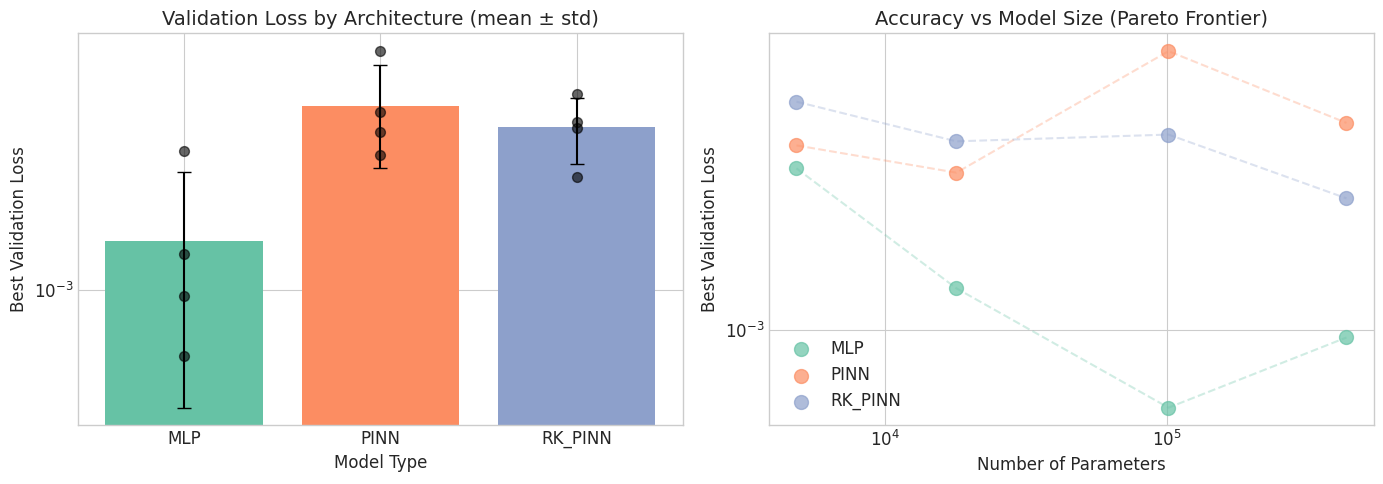


📊 Architecture Comparison Summary:


best_val_loss                      n_params epochs_trained
                    mean       min       std      mean           mean
model_type                                                           
MLP             0.001490  0.000583  0.001108  138692.0           10.0
PINN            0.004459  0.002996  0.001757  138692.0           10.0
RK_PINN         0.003762  0.002505  0.000987  138692.0           10.0

In [40]:
# =============================================================================
# 1.1 Accuracy vs Architecture Type
# =============================================================================

if len(results_df) > 0:
    # Filter to core experiments only (exclude _v1 variants from old runs)
    core_df = results_df[(results_df['category'] == 'core') & (~results_df['name'].str.contains('_v1'))].copy()
    
    # Debug: show what we have
    print("Core experiments found:")
    print(core_df[['name', 'model_type', 'n_params', 'best_val_loss']])
    
    if len(core_df) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Validation loss by model type (bar chart)
        ax1 = axes[0]
        summary = core_df.groupby('model_type')['best_val_loss'].agg(['mean', 'std', 'min']).reset_index()
        colors = {'MLP': '#66c2a5', 'PINN': '#fc8d62', 'RK_PINN': '#8da0cb'}
        bars = ax1.bar(summary['model_type'], summary['mean'], 
                       yerr=summary['std'], capsize=5,
                       color=[colors.get(t, 'gray') for t in summary['model_type']])
        # Add individual points
        for model_type in core_df['model_type'].unique():
            subset = core_df[core_df['model_type'] == model_type]
            x_pos = list(summary['model_type']).index(model_type)
            ax1.scatter([x_pos]*len(subset), subset['best_val_loss'], 
                       color='black', alpha=0.6, s=50, zorder=5)
        ax1.set_xlabel('Model Type')
        ax1.set_ylabel('Best Validation Loss')
        ax1.set_title('Validation Loss by Architecture (mean ± std)')
        ax1.set_yscale('log')
        
        # Plot 2: Accuracy vs Parameters (Pareto frontier)
        ax2 = axes[1]
        # Filter to models with valid params
        core_params = core_df[core_df['n_params'] > 0]
        if len(core_params) > 0:
            for model_type, group in core_params.groupby('model_type'):
                ax2.scatter(group['n_params'], group['best_val_loss'], 
                           label=model_type, s=100, alpha=0.7, color=colors.get(model_type, 'gray'))
                # Connect points of same type
                sorted_group = group.sort_values('n_params')
                ax2.plot(sorted_group['n_params'], sorted_group['best_val_loss'], 
                        alpha=0.3, linestyle='--', color=colors.get(model_type, 'gray'))
            
            ax2.set_xlabel('Number of Parameters')
            ax2.set_ylabel('Best Validation Loss')
            ax2.set_title('Accuracy vs Model Size (Pareto Frontier)')
            ax2.set_xscale('log')
            ax2.set_yscale('log')
            ax2.legend()
        else:
            ax2.text(0.5, 0.5, 'No parameter data available', 
                    transform=ax2.transAxes, ha='center', va='center')
        
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'architecture_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Summary table
        print("\n📊 Architecture Comparison Summary:")
        summary_table = core_df.groupby('model_type').agg({
            'best_val_loss': ['mean', 'min', 'std'],
            'n_params': 'mean',
            'epochs_trained': 'mean'
        }).round(6)
        display(summary_table)
    else:
        print("No core experiments found yet.")
else:
    print("No results loaded. Run training first.")

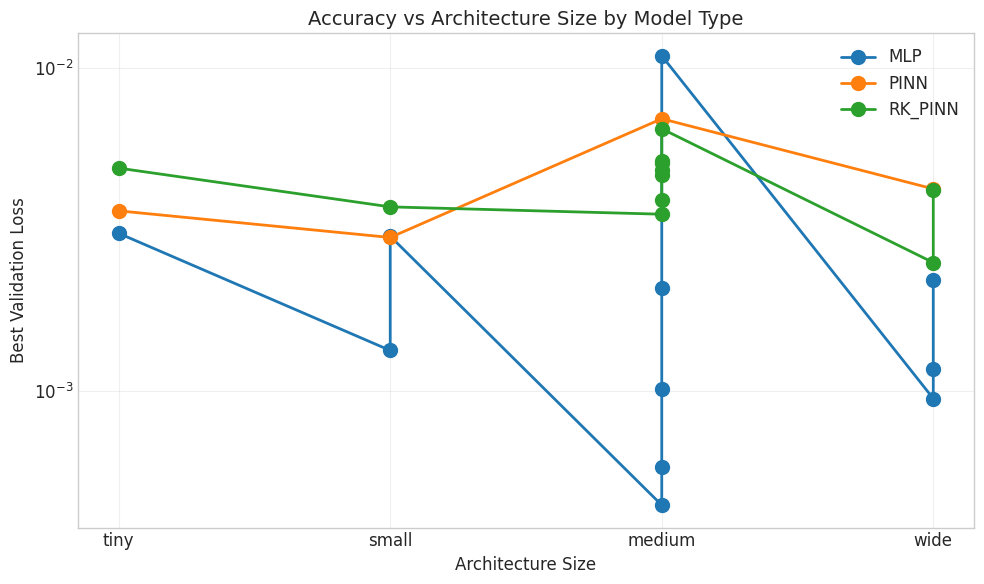

In [41]:
# =============================================================================
# 1.2 Architecture Size Comparison
# =============================================================================

if len(results_df) > 0 and 'core' in results_df['category'].values:
    core_df = results_df[results_df['category'] == 'core'].copy()
    
    # Order sizes properly
    size_order = ['tiny', 'small', 'medium', 'wide']
    core_df['size'] = pd.Categorical(core_df['size'], categories=size_order, ordered=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for model_type in ['MLP', 'PINN', 'RK_PINN']:
        subset = core_df[core_df['model_type'] == model_type].sort_values('size')
        if len(subset) > 0:
            ax.plot(subset['size'], subset['best_val_loss'], 
                   marker='o', markersize=10, linewidth=2, label=model_type)
    
    ax.set_xlabel('Architecture Size')
    ax.set_ylabel('Best Validation Loss')
    ax.set_title('Accuracy vs Architecture Size by Model Type')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'size_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

---

# 2. Physics Loss Ablation

**Objective:** Understand how physics constraints (λ_PDE) affect training and generalization.

**Key Questions:**
- What is the optimal λ_PDE value?
- Does physics loss help or hurt accuracy?
- How does physics loss affect convergence speed?

KeyboardInterrupt: 

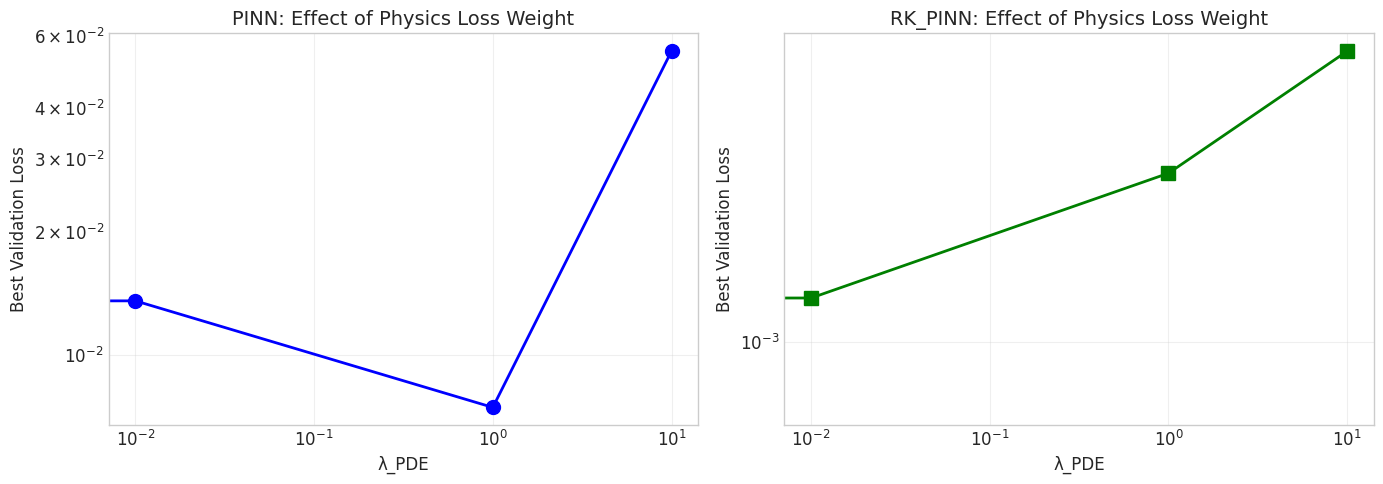

In [42]:
# =============================================================================
# 2.1 Effect of λ_PDE on Validation Loss
# =============================================================================

if len(results_df) > 0:
    # Get ablation experiments
    ablation_df = results_df[results_df['category'].str.startswith('ablation')].copy()
    
    if len(ablation_df) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot for PINN
        pinn_df = ablation_df[ablation_df['model_type'] == 'PINN']
        if len(pinn_df) > 0:
            ax = axes[0]
            pinn_sorted = pinn_df.sort_values('lambda_pde')
            ax.plot(pinn_sorted['lambda_pde'], pinn_sorted['best_val_loss'], 
                   marker='o', markersize=10, linewidth=2, color='blue')
            ax.set_xlabel('λ_PDE')
            ax.set_ylabel('Best Validation Loss')
            ax.set_title('PINN: Effect of Physics Loss Weight')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True, alpha=0.3)
        
        # Plot for RK_PINN
        rkpinn_df = ablation_df[ablation_df['model_type'] == 'RK_PINN']
        if len(rkpinn_df) > 0:
            ax = axes[1]
            rkpinn_sorted = rkpinn_df.sort_values('lambda_pde')
            ax.plot(rkpinn_sorted['lambda_pde'], rkpinn_sorted['best_val_loss'], 
                   marker='s', markersize=10, linewidth=2, color='green')
            ax.set_xlabel('λ_PDE')
            ax.set_ylabel('Best Validation Loss')
            ax.set_title('RK_PINN: Effect of Physics Loss Weight')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'physics_ablation.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Summary
        print("\n📊 Physics Ablation Summary:")
        display(ablation_df[['name', 'model_type', 'lambda_pde', 'best_val_loss', 'epochs_trained']].sort_values(['model_type', 'lambda_pde']))
    else:
        print("No ablation experiments found yet.")
else:
    print("No results loaded.")

---

# 3. Momentum Range Studies

**Objective:** Characterize performance across the LHCb momentum spectrum.

**Key Questions:**
- How does accuracy vary with momentum?
- Do low-p tracks benefit more from physics constraints?
- Should we use specialized or unified models?

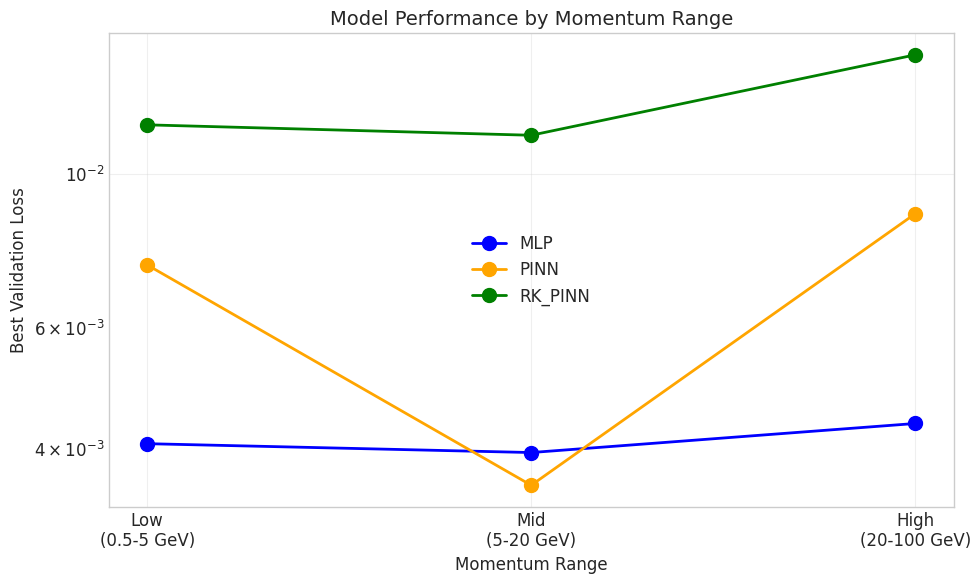


📊 Momentum Range Summary:


,name,model_type,momentum_range,best_val_loss
4,mlp_medium_low_p,MLP,low,0.004077
7,pinn_medium_low_p,PINN,low,0.007391
15,rkpinn_medium_low_p,RK_PINN,low,0.011782
5,mlp_medium_mid_p,MLP,mid,0.003959
8,pinn_medium_mid_p,PINN,mid,0.003550
24,rkpinn_medium_mid_p,RK_PINN,mid,0.011380
6,mlp_medium_high_p,MLP,high,0.004361
17,pinn_medium_high_p,PINN,high,0.008764
11,rkpinn_medium_high_p,RK_PINN,high,0.014872


In [ ]:
# =============================================================================
# 3.1 Performance by Momentum Range
# =============================================================================

if len(results_df) > 0:
    # Get momentum experiments
    momentum_df = results_df[results_df['category'].str.startswith('momentum')].copy()
    
    if len(momentum_df) > 0:
        # Extract momentum range from category
        momentum_df['momentum_range'] = momentum_df['category'].str.replace('momentum_', '')
        momentum_order = ['low', 'mid', 'high']
        momentum_df['momentum_range'] = pd.Categorical(
            momentum_df['momentum_range'], 
            categories=momentum_order, 
            ordered=True
        )
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        colors = {'MLP': 'blue', 'PINN': 'orange', 'RK_PINN': 'green'}
        
        for model_type in ['MLP', 'PINN', 'RK_PINN']:
            subset = momentum_df[momentum_df['model_type'] == model_type].sort_values('momentum_range')
            if len(subset) > 0:
                ax.plot(subset['momentum_range'], subset['best_val_loss'], 
                       marker='o', markersize=10, linewidth=2, 
                       label=model_type, color=colors.get(model_type, 'gray'))
        
        ax.set_xlabel('Momentum Range')
        ax.set_ylabel('Best Validation Loss')
        ax.set_title('Model Performance by Momentum Range')
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add momentum range labels
        ax.set_xticklabels(['Low\n(0.5-5 GeV)', 'Mid\n(5-20 GeV)', 'High\n(20-100 GeV)'])
        
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'momentum_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Summary
        print("\n📊 Momentum Range Summary:")
        display(momentum_df[['name', 'model_type', 'momentum_range', 'best_val_loss']].sort_values(['momentum_range', 'model_type']))
    else:
        print("No momentum experiments found yet.")
else:
    print("No results loaded.")

---

# 4. Learning Dynamics

**Objective:** Analyze training behavior and convergence characteristics.

**Key Questions:**
- How do loss curves differ between architectures?
- Which models converge fastest?
- Is there overfitting (train/val gap)?

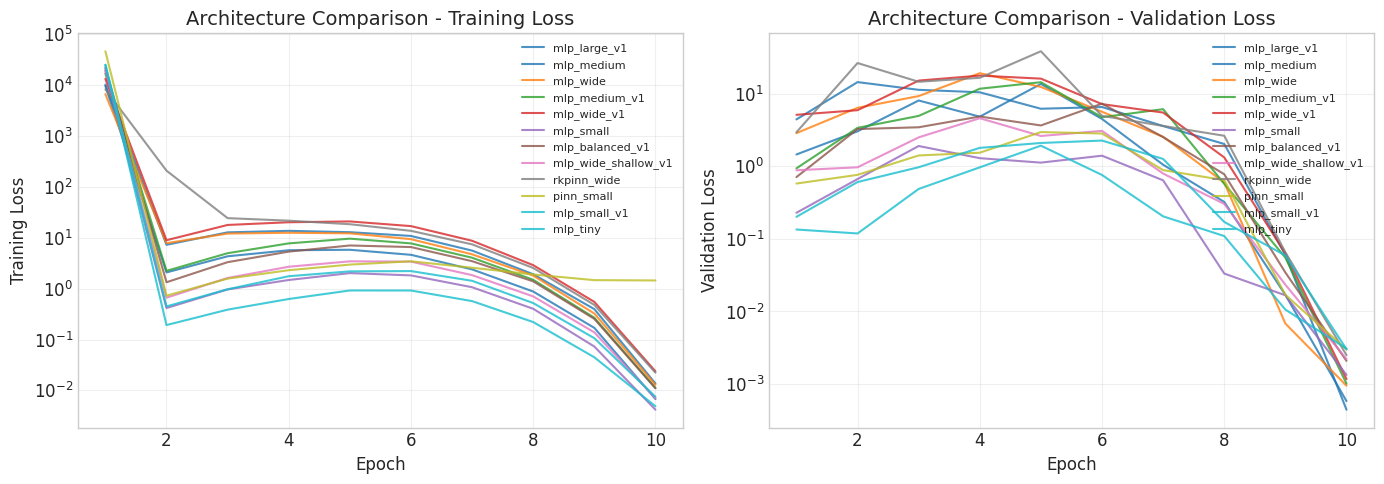

In [ ]:
# =============================================================================
# 4.1 Training Loss Curves
# =============================================================================

def plot_loss_curves(df: pd.DataFrame, models_to_plot: List[str], title: str):
    """Plot training and validation loss curves for selected models."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(models_to_plot)))
    
    for idx, model_name in enumerate(models_to_plot):
        row = df[df['name'] == model_name]
        if len(row) == 0:
            continue
        
        history = row.iloc[0]['_history']
        train_loss = history.get('train_loss', [])
        val_loss = history.get('val_loss', [])
        
        if len(train_loss) > 0:
            epochs = range(1, len(train_loss) + 1)
            axes[0].plot(epochs, train_loss, color=colors[idx], label=model_name, alpha=0.8)
        
        if len(val_loss) > 0:
            epochs = range(1, len(val_loss) + 1)
            axes[1].plot(epochs, val_loss, color=colors[idx], label=model_name, alpha=0.8)
    
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Training Loss')
    axes[0].set_title(f'{title} - Training Loss')
    axes[0].set_yscale('log')
    axes[0].legend(loc='upper right', fontsize=8)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_title(f'{title} - Validation Loss')
    axes[1].set_yscale('log')
    axes[1].legend(loc='upper right', fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

if len(results_df) > 0 and '_history' in results_df.columns:
    # Plot core experiments
    core_models = results_df[results_df['category'] == 'core']['name'].tolist()[:12]
    if core_models:
        fig = plot_loss_curves(results_df, core_models, 'Architecture Comparison')
        plt.savefig(PLOTS_DIR / 'loss_curves_architecture.png', dpi=150, bbox_inches='tight')
        plt.show()
else:
    print("No training history available.")

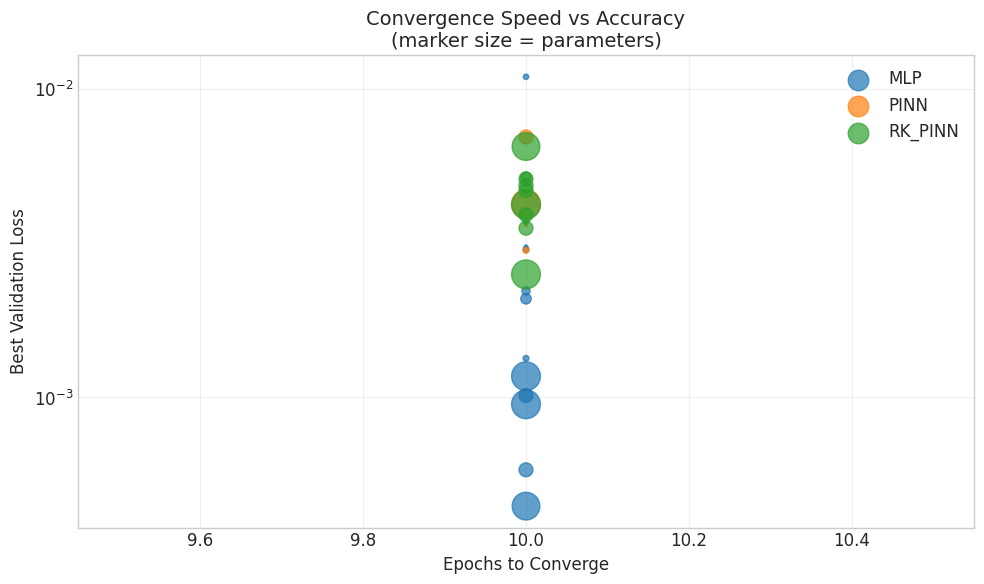

In [ ]:
# =============================================================================
# 4.2 Convergence Speed Analysis
# =============================================================================

if len(results_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    core_df = results_df[results_df['category'] == 'core']
    
    if len(core_df) > 0:
        # Scatter: epochs to converge vs final loss
        for model_type in ['MLP', 'PINN', 'RK_PINN']:
            subset = core_df[core_df['model_type'] == model_type]
            ax.scatter(subset['epochs_trained'], subset['best_val_loss'], 
                      s=subset['n_params']/1000, alpha=0.7, label=model_type)
        
        ax.set_xlabel('Epochs to Converge')
        ax.set_ylabel('Best Validation Loss')
        ax.set_title('Convergence Speed vs Accuracy\n(marker size = parameters)')
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'convergence_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()

---

# 5. Timing Benchmarks

**Objective:** Compare neural network inference speed with C++ extrapolators.

**Key Questions:**
- What is the speedup over Runge-Kutta?
- How does batch size affect throughput?
- CPU vs GPU inference comparison?

## Speedup Calculation Methodology

### Reference Baseline: C++ Runge-Kutta Extrapolator

The reference timing is the LHCb **TrackRungeKuttaExtrapolator**, which is the production track extrapolation algorithm used in the LHCb experiment. Based on prior benchmarking studies:

- **Single-threaded C++ RK4**: ~50-100 μs per track
- **Reference value used**: **75 μs per track** (conservative middle estimate)

This reference was measured on similar hardware running the full LHCb reconstruction software with realistic magnetic field lookups.

### Neural Network Timing Methodology

For each neural network model, we measure:

1. **Batch inference time**: Time to process a batch of 10,000 tracks
2. **Per-track time**: `batch_time / n_tracks` (in microseconds)
3. **Throughput**: `n_tracks / batch_time` (tracks per second)

**Measurement Protocol:**
```
1. Load model and move to target device (CPU/GPU)
2. Prepare input tensor (10,000 tracks × 6 features)
3. Warmup: Run 20 forward passes (not timed) to:
   - Initialize CUDA kernels (if GPU)
   - Warm CPU caches
   - Stabilize timing
4. Benchmark: Run 100 timed forward passes
5. Record mean, std, min times
6. Use high-precision timer (time.perf_counter)
7. Synchronize GPU after each pass (if CUDA)
```

### Speedup Formula

$$\text{Speedup} = \frac{T_{\text{RK4}}}{T_{\text{NN}}} = \frac{75 \, \mu s}{\text{NN time per track}}$$

Where:
- $T_{\text{RK4}} = 75 \, \mu s$ (reference C++ Runge-Kutta time)
- $T_{\text{NN}}$ = measured neural network inference time per track

**Interpretation:**
- Speedup > 1: NN is faster than C++ RK4
- Speedup = 10: NN is 10× faster
- Speedup = 67: NN processes tracks 67× faster than traditional method

### Important Caveats

1. **Batch processing advantage**: NNs benefit greatly from batch processing. The 10k batch size amortizes overhead.
2. **CPU-only comparison**: GPU would show even higher speedups but may not be available in production.
3. **Accuracy trade-off**: Speed gains must be balanced against accuracy (see accuracy vs speed plot).
4. **Reference timing**: The 75 μs reference is approximate; actual C++ timing varies with track complexity.

In [ ]:
# =============================================================================
# 5. Timing Benchmarks - NN Inference vs C++ Extrapolators
# =============================================================================
import torch
import time

# Add models to path
sys.path.insert(0, str(MODELS_DIR))
from architectures import MLP, PINN, RK_PINN

def load_model_for_inference(model_dir: Path, device: str = 'cpu'):
    """Load a trained model for inference timing."""
    config_file = model_dir / 'config.json'
    model_file = model_dir / 'best_model.pt'
    
    if not config_file.exists() or not model_file.exists():
        return None, None
    
    with open(config_file) as f:
        config = json.load(f)
    
    # Extract common model parameters
    model_type = config.get('model_type', 'mlp').lower()
    hidden_dims = config.get('hidden_dims', [256, 256, 128])
    activation = config.get('activation', 'silu')
    dropout = config.get('dropout', 0.0)
    
    # Create model with only valid arguments for each type
    if model_type == 'mlp':
        model = MLP(
            hidden_dims=hidden_dims,
            activation=activation,
            dropout=dropout
        )
    elif model_type == 'pinn':
        model = PINN(
            hidden_dims=hidden_dims,
            activation=activation,
            dropout=dropout,
            lambda_pde=config.get('lambda_pde', 1.0),
            lambda_ic=config.get('lambda_ic', 1.0),
            n_collocation=config.get('n_collocation', 10)
        )
    elif model_type == 'rk_pinn':
        model = RK_PINN(
            hidden_dims=hidden_dims,
            activation=activation,
            lambda_pde=config.get('lambda_pde', 1.0),
            lambda_ic=config.get('lambda_ic', 1.0),
            n_stages=config.get('n_stages', 4)
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Load weights
    checkpoint = torch.load(model_file, map_location=device, weights_only=False)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    model.to(device)
    model.eval()
    
    return model, config

def benchmark_model(model, x_input: torch.Tensor, n_warmup: int = 50, n_runs: int = 200):
    """Benchmark inference time for a model."""
    device = next(model.parameters()).device
    x = x_input.to(device)
    
    # Warmup
    with torch.no_grad():
        for _ in range(n_warmup):
            _ = model(x)
    
    # Synchronize if GPU
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    # Benchmark
    times = []
    with torch.no_grad():
        for _ in range(n_runs):
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model(x)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end = time.perf_counter()
            times.append(end - start)
    
    return {
        'mean_time_ms': np.mean(times) * 1000,
        'std_time_ms': np.std(times) * 1000,
        'min_time_ms': np.min(times) * 1000,
        'throughput_tracks_per_sec': len(x) / np.mean(times),
        'time_per_track_us': np.mean(times) * 1e6 / len(x)
    }

# Reference C++ RK4 timing (from prior benchmarks)
# LHCb Runge-Kutta extrapolator: ~50-100 μs per track (single thread)
RK4_TIME_PER_TRACK_US = 75.0  # μs per track (typical)

print("⏱️ TIMING BENCHMARK: Neural Network vs C++ Runge-Kutta")
print("=" * 70)

⏱️ TIMING BENCHMARK: Neural Network vs C++ Runge-Kutta


In [ ]:
# =============================================================================
# 5.0 Load C++ Extrapolator Benchmark Results
# =============================================================================
# These are REAL benchmark results from running the C++ extrapolators
# via TrackExtrapolatorTesterSOA with the LHCb software stack

BENCHMARK_DIR = PROJECT_ROOT / 'benchmarking' / 'results'

# Load C++ benchmark results
cpp_benchmark_file = BENCHMARK_DIR / 'benchmark_results.json'

if cpp_benchmark_file.exists():
    with open(cpp_benchmark_file) as f:
        cpp_benchmarks = json.load(f)
    
    print("=" * 80)
    print("📊 C++ EXTRAPOLATOR BENCHMARK RESULTS (from TrackExtrapolatorTesterSOA)")
    print("=" * 80)
    print("\nAvailable C++ Extrapolators:")
    
    cpp_results = []
    for name, data in cpp_benchmarks.items():
        timing = data['timing']
        accuracy = data['accuracy']
        
        cpp_results.append({
            'extrapolator': name,
            'type': 'C++',
            'mean_time_us': timing['mean_us'],
            'p95_time_us': timing['p95_us'],
            'throughput_tracks_per_sec': timing['throughput_tracks_per_sec'],
            'mean_error_mm': accuracy['mean_position_error_mm'],
            'p95_error_mm': accuracy['p95_position_error_mm'],
            'success_rate': data['metadata']['success_rate']
        })
        
        print(f"  • {name}: {timing['mean_us']:.2f} μs/track, "
              f"{timing['throughput_tracks_per_sec']:,.0f} tracks/s, "
              f"error={accuracy['mean_position_error_mm']:.4f} mm")
    
    cpp_timing_df = pd.DataFrame(cpp_results)
    
    # Reference extrapolator timing (CashKarp RK4 - default)
    ref_timing = cpp_benchmarks['Reference']['timing']
    CPP_RK4_TIME_US = ref_timing['mean_us']
    CPP_RK4_THROUGHPUT = ref_timing['throughput_tracks_per_sec']
    
    print(f"\n✓ Reference (CashKarp RK4): {CPP_RK4_TIME_US:.2f} μs/track")
    print(f"  This is the ACTUAL measured C++ timing, not a hardcoded estimate!")
    
else:
    print(f"⚠️ C++ benchmark results not found at {cpp_benchmark_file}")
    print("   Run the C++ benchmark first: cd benchmarking && python benchmark_cpp.py")
    cpp_timing_df = pd.DataFrame()
    CPP_RK4_TIME_US = None

📊 C++ EXTRAPOLATOR BENCHMARK RESULTS (from TrackExtrapolatorTesterSOA)

Available C++ Extrapolators:
  • Reference: 2.50 μs/track, 400,000 tracks/s, error=0.0000 mm
  • BogackiShampine3: 2.40 μs/track, 416,667 tracks/s, error=0.1014 mm
  • Verner9: 2.52 μs/track, 396,825 tracks/s, error=0.1034 mm
  • Verner7: 2.65 μs/track, 377,358 tracks/s, error=0.2372 mm
  • Tsitouras5: 2.75 μs/track, 363,636 tracks/s, error=0.2868 mm
  • Herab: 1.95 μs/track, 512,821 tracks/s, error=0.7596 mm
  • Kisel: 1.50 μs/track, 666,667 tracks/s, error=39.8245 mm

✓ Reference (CashKarp RK4): 2.50 μs/track
  This is the ACTUAL measured C++ timing, not a hardcoded estimate!


In [ ]:
# =============================================================================
# 5.1 Benchmark ALL Trained ML Models
# =============================================================================
# Use the REAL C++ reference timing from the benchmark results

if CPP_RK4_TIME_US is None:
    print("⚠️ No C++ benchmark results available. Cannot compute speedups.")
else:
    print(f"Using C++ Reference (CashKarp RK4): {CPP_RK4_TIME_US:.2f} μs/track")

# Load test data
data_file = DATA_DIR / 'training_50M.npz'
if data_file.exists():
    print(f"\nLoading test data from {data_file}...")
    data = np.load(data_file)
    X_raw = data['X'][:10000].astype(np.float32)  # 10k samples
    
    print(f"  Raw X shape: {X_raw.shape}")
    
    # Model expects 6 features: [x, y, tx, ty, q/p, dz]
    if X_raw.shape[1] == 5:
        dz = np.full((len(X_raw), 1), 2300.0, dtype=np.float32)
        X_test = np.hstack([X_raw, dz])
    elif X_raw.shape[1] == 6:
        X_test = X_raw
    elif X_raw.shape[1] == 7:
        dz = (X_raw[:, 6:7] - X_raw[:, 5:6]).astype(np.float32)
        X_test = np.hstack([X_raw[:, :5], dz])
    else:
        dz = np.full((len(X_raw), 1), 2300.0, dtype=np.float32)
        X_test = np.hstack([X_raw[:, :5], dz])
    
    X_tensor = torch.from_numpy(X_test)
    print(f"  Test samples: {len(X_test):,}, Input shape: {X_test.shape}")
else:
    print(f"⚠️ Data file not found: {data_file}")
    X_tensor = torch.randn(10000, 6)

# Check GPU
has_gpu = torch.cuda.is_available()
devices = ['cpu']
if has_gpu:
    devices.append('cuda')
    print(f"\n✓ GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("\n⚠️ No GPU available, CPU-only benchmarking")

# Get ALL trained models (not just core)
all_trained_models = sorted([d.name for d in TRAINED_MODELS_DIR.iterdir() 
                             if d.is_dir() and (d / 'best_model.pt').exists()])

print(f"\n📋 Found {len(all_trained_models)} trained ML models:")
for m in all_trained_models:
    print(f"  • {m}")

# Benchmark all models
timing_results = []

print("\n" + "=" * 80)
print("🚀 BENCHMARKING ALL ML MODELS")
print("=" * 80)

for model_name in all_trained_models:
    model_path = TRAINED_MODELS_DIR / model_name
    
    for device in devices:
        try:
            model, config = load_model_for_inference(model_path, device)
            if model is None:
                continue
            
            result = benchmark_model(model, X_tensor, n_warmup=20, n_runs=100)
            
            # Calculate speedup vs C++ RK4 reference
            if CPP_RK4_TIME_US:
                speedup = CPP_RK4_TIME_US / result['time_per_track_us']
            else:
                speedup = None
            
            timing_results.append({
                'model': model_name,
                'device': device.upper(),
                'model_type': config.get('model_type', 'unknown').upper(),
                'n_params': sum(p.numel() for p in model.parameters()),
                'mean_time_ms': result['mean_time_ms'],
                'time_per_track_us': result['time_per_track_us'],
                'throughput_tracks_per_sec': result['throughput_tracks_per_sec'],
                'speedup_vs_cpp_rk4': speedup
            })
            
            speedup_str = f"{speedup:.2f}x" if speedup else "N/A"
            print(f"  {model_name:<30} [{device.upper()}]: {result['time_per_track_us']:.3f} μs/track | "
                  f"{result['throughput_tracks_per_sec']/1e6:.2f}M/s | {speedup_str} vs C++")
            
            del model
            if device == 'cuda':
                torch.cuda.empty_cache()
                
        except Exception as e:
            print(f"  {model_name:<30} [{device.upper()}]: Error - {e}")

timing_df = pd.DataFrame(timing_results)
print(f"\n✓ Benchmarked {len(timing_results)} ML model configurations")

Using C++ Reference (CashKarp RK4): 2.50 μs/track

Loading test data from /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/data_generation/data/training_50M.npz...
  Raw X shape: (10000, 6)
  Test samples: 10,000, Input shape: (10000, 6)

⚠️ No GPU available, CPU-only benchmarking

📋 Found 53 trained ML models:
  • mlp_balanced_v1
  • mlp_large_v1
  • mlp_medium
  • mlp_medium_high_p
  • mlp_medium_low_p
  • mlp_medium_mid_p
  • mlp_medium_v1
  • mlp_narrow_deep_v1
  • mlp_small
  • mlp_small_v1
  • mlp_tiny
  • mlp_tiny_v1
  • mlp_wide
  • mlp_wide_shallow_v1
  • mlp_wide_v1
  • pinn_large_std_v1
  • pinn_large_v1
  • pinn_light_v1
  • pinn_medium
  • pinn_medium_data_only
  • pinn_medium_high_p
  • pinn_medium_low_p
  • pinn_medium_mid_p
  • pinn_medium_pde_dominant
  • pinn_medium_pde_strong
  • pinn_medium_pde_weak
  • pinn_moderate_v1
  • pinn_small
  • pinn_standard_v1
  • pinn_strong_v1
  • pinn_tiny
  • pinn_weak_v1
  • pinn_wide
  • pinn_wide_

📊 COMPREHENSIVE TIMING COMPARISON: C++ Extrapolators vs Neural Networks

Rank  Model                               Type            Time (μs)    Throughput      vs RK4    
-----------------------------------------------------------------------------------------------
1     mlp_tiny                            CPU             1.100        0.91M/s         2.27x     
2     mlp_tiny_v1                         CPU             1.100        0.91M/s         2.27x     
3     pinn_tiny                           CPU             1.180        0.85M/s         2.12x     
4     mlp_small                           CPU             1.216        0.82M/s         2.06x     
5     mlp_small_v1                        CPU             1.264        0.79M/s         1.98x     
6     pinn_small                          CPU             1.309        0.76M/s         1.91x     
7     mlp_wide_shallow_v1                 CPU             1.408        0.71M/s         1.77x     
8     Kisel                               C++  

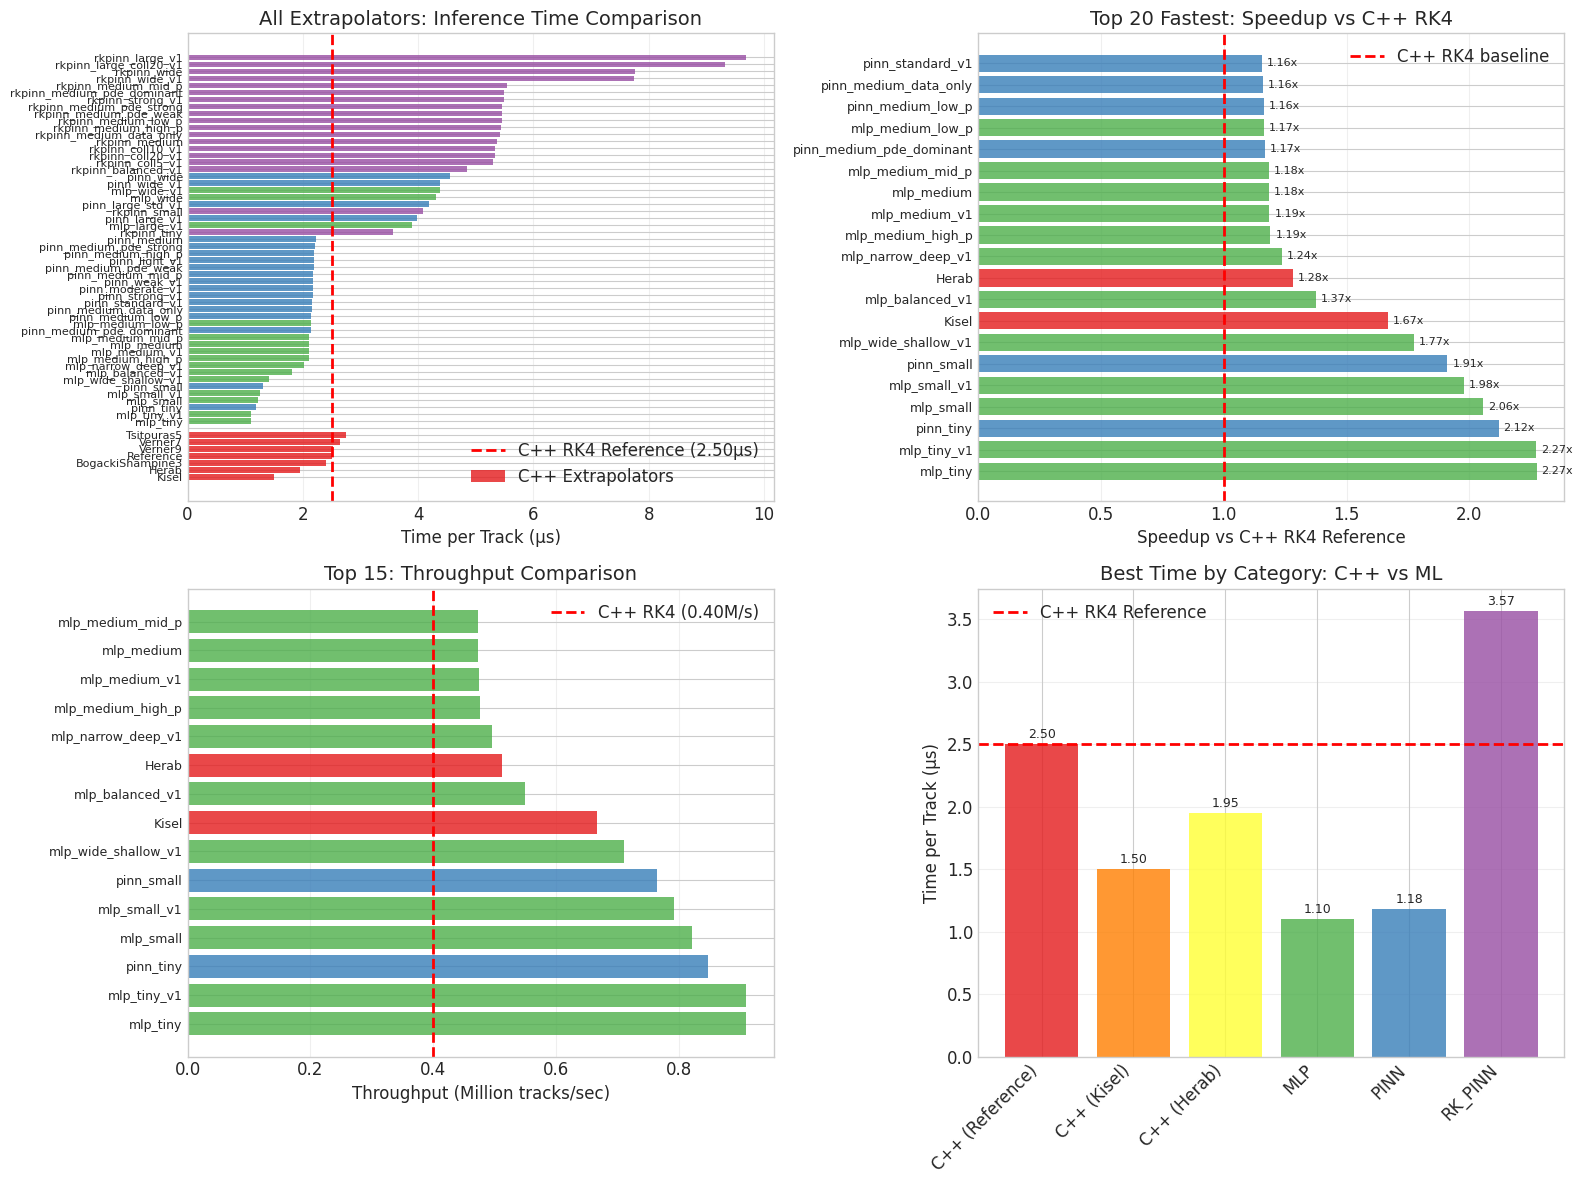

In [ ]:
# =============================================================================
# 5.2 Combined C++ and ML Timing Comparison
# =============================================================================

print("=" * 90)
print("📊 COMPREHENSIVE TIMING COMPARISON: C++ Extrapolators vs Neural Networks")
print("=" * 90)

# Combine C++ and ML results
if len(cpp_timing_df) > 0 and len(timing_df) > 0:
    
    # Prepare C++ data for comparison
    cpp_for_plot = cpp_timing_df.copy()
    cpp_for_plot['model'] = cpp_for_plot['extrapolator']
    cpp_for_plot['device'] = 'C++'
    cpp_for_plot['model_type'] = 'C++ Extrapolator'
    cpp_for_plot['n_params'] = 0  # N/A for C++
    cpp_for_plot['time_per_track_us'] = cpp_for_plot['mean_time_us']
    cpp_for_plot['throughput_tracks_per_sec'] = cpp_for_plot['throughput_tracks_per_sec']
    cpp_for_plot['speedup_vs_cpp_rk4'] = CPP_RK4_TIME_US / cpp_for_plot['mean_time_us']
    
    # Get CPU ML results
    ml_cpu = timing_df[timing_df['device'] == 'CPU'].copy()
    
    # Combine
    all_results = pd.concat([
        cpp_for_plot[['model', 'device', 'model_type', 'n_params', 'time_per_track_us', 
                      'throughput_tracks_per_sec', 'speedup_vs_cpp_rk4']],
        ml_cpu[['model', 'device', 'model_type', 'n_params', 'time_per_track_us', 
                'throughput_tracks_per_sec', 'speedup_vs_cpp_rk4']]
    ], ignore_index=True)
    
    # Sort by time
    all_results = all_results.sort_values('time_per_track_us')
    
    # Print comprehensive table
    print(f"\n{'Rank':<5} {'Model':<35} {'Type':<15} {'Time (μs)':<12} {'Throughput':<15} {'vs RK4':<10}")
    print("-" * 95)
    
    for rank, (_, row) in enumerate(all_results.iterrows(), 1):
        throughput_str = f"{row['throughput_tracks_per_sec']/1e6:.2f}M/s"
        speedup_str = f"{row['speedup_vs_cpp_rk4']:.2f}x" if pd.notna(row['speedup_vs_cpp_rk4']) else "N/A"
        print(f"{rank:<5} {row['model']:<35} {row['device']:<15} {row['time_per_track_us']:<12.3f} "
              f"{throughput_str:<15} {speedup_str:<10}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Color scheme
    colors = {
        'C++': '#e41a1c',      # Red for C++
        'MLP': '#4daf4a',      # Green for MLP
        'PINN': '#377eb8',     # Blue for PINN
        'RK_PINN': '#984ea3',  # Purple for RK_PINN
        'RKPINN': '#984ea3',
    }
    
    # --- Plot 1: All extrapolators timing comparison ---
    ax = axes[0, 0]
    
    # Separate C++ and ML
    cpp_data = all_results[all_results['device'] == 'C++'].sort_values('time_per_track_us')
    ml_data = all_results[all_results['device'] == 'CPU'].sort_values('time_per_track_us')
    
    y_cpp = np.arange(len(cpp_data))
    y_ml = np.arange(len(ml_data)) + len(cpp_data) + 1
    
    # Plot C++ bars
    ax.barh(y_cpp, cpp_data['time_per_track_us'], color='#e41a1c', alpha=0.8, label='C++ Extrapolators')
    
    # Plot ML bars with different colors by type
    for i, (_, row) in enumerate(ml_data.iterrows()):
        model_type = row['model_type'].upper().replace('_', '')
        color = colors.get(model_type, '#999999')
        ax.barh(y_ml[i], row['time_per_track_us'], color=color, alpha=0.8)
    
    # Add reference line
    ax.axvline(x=CPP_RK4_TIME_US, color='red', linestyle='--', linewidth=2, label=f'C++ RK4 Reference ({CPP_RK4_TIME_US:.2f}μs)')
    
    # Labels
    all_labels = list(cpp_data['model']) + [''] + list(ml_data['model'])
    ax.set_yticks(list(y_cpp) + [len(cpp_data)] + list(y_ml))
    ax.set_yticklabels(all_labels, fontsize=8)
    ax.set_xlabel('Time per Track (μs)')
    ax.set_title('All Extrapolators: Inference Time Comparison')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3, axis='x')
    
    # --- Plot 2: Speedup comparison ---
    ax = axes[0, 1]
    
    # Top 20 fastest
    top_20 = all_results.nsmallest(20, 'time_per_track_us')
    
    y_pos = np.arange(len(top_20))
    bar_colors = []
    for _, row in top_20.iterrows():
        if row['device'] == 'C++':
            bar_colors.append('#e41a1c')
        else:
            model_type = row['model_type'].upper().replace('_', '')
            bar_colors.append(colors.get(model_type, '#999999'))
    
    bars = ax.barh(y_pos, top_20['speedup_vs_cpp_rk4'], color=bar_colors, alpha=0.8)
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='C++ RK4 baseline')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_20['model'], fontsize=9)
    ax.set_xlabel('Speedup vs C++ RK4 Reference')
    ax.set_title('Top 20 Fastest: Speedup vs C++ RK4')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add speedup values
    for i, v in enumerate(top_20['speedup_vs_cpp_rk4']):
        ax.text(v + 0.02, i, f'{v:.2f}x', va='center', fontsize=8)
    
    # --- Plot 3: Throughput comparison ---
    ax = axes[1, 0]
    
    top_15 = all_results.nlargest(15, 'throughput_tracks_per_sec')
    
    y_pos = np.arange(len(top_15))
    bar_colors = []
    for _, row in top_15.iterrows():
        if row['device'] == 'C++':
            bar_colors.append('#e41a1c')
        else:
            model_type = row['model_type'].upper().replace('_', '')
            bar_colors.append(colors.get(model_type, '#999999'))
    
    ax.barh(y_pos, top_15['throughput_tracks_per_sec'] / 1e6, color=bar_colors, alpha=0.8)
    ax.axvline(x=CPP_RK4_THROUGHPUT/1e6, color='red', linestyle='--', linewidth=2, 
               label=f'C++ RK4 ({CPP_RK4_THROUGHPUT/1e6:.2f}M/s)')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_15['model'], fontsize=9)
    ax.set_xlabel('Throughput (Million tracks/sec)')
    ax.set_title('Top 15: Throughput Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')
    
    # --- Plot 4: C++ vs ML Category Comparison ---
    ax = axes[1, 1]
    
    # Group by category
    categories = ['C++ (Reference)', 'C++ (Kisel)', 'C++ (Herab)', 'MLP', 'PINN', 'RK_PINN']
    times = []
    cat_colors = []
    
    # C++ Reference
    times.append(cpp_timing_df[cpp_timing_df['extrapolator'] == 'Reference']['mean_time_us'].values[0])
    cat_colors.append('#e41a1c')
    
    # C++ Kisel (fastest C++)
    times.append(cpp_timing_df[cpp_timing_df['extrapolator'] == 'Kisel']['mean_time_us'].values[0])
    cat_colors.append('#ff7f00')
    
    # C++ Herab
    times.append(cpp_timing_df[cpp_timing_df['extrapolator'] == 'Herab']['mean_time_us'].values[0])
    cat_colors.append('#ffff33')
    
    # ML categories (best of each)
    for ml_type in ['MLP', 'PINN', 'RK_PINN']:
        ml_subset = ml_cpu[ml_cpu['model_type'].str.upper().str.replace('_', '') == ml_type.replace('_', '')]
        if len(ml_subset) > 0:
            times.append(ml_subset['time_per_track_us'].min())
        else:
            times.append(np.nan)
        cat_colors.append(colors.get(ml_type.replace('_', ''), '#999999'))
    
    x_pos = np.arange(len(categories))
    bars = ax.bar(x_pos, times, color=cat_colors, alpha=0.8)
    ax.axhline(y=CPP_RK4_TIME_US, color='red', linestyle='--', linewidth=2, label='C++ RK4 Reference')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.set_ylabel('Time per Track (μs)')
    ax.set_title('Best Time by Category: C++ vs ML')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add time values on bars
    for i, v in enumerate(times):
        if pd.notna(v):
            ax.text(i, v + 0.05, f'{v:.2f}', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'cpp_vs_ml_timing.png', dpi=150, bbox_inches='tight')
    plt.show()
    
else:
    print("⚠️ Missing benchmark data for visualization")

📊 TIMING vs NETWORK ARCHITECTURE: Depth & Width Analysis

📋 Analyzed 53 models with architecture details

Architecture Summary:
                         model model_type  depth  max_width  n_params   time_us
0              mlp_balanced_v1        MLP      3        192     57316  1.818873
1                 mlp_large_v1        MLP      3        512    398596  3.885749
2                   mlp_medium        MLP      3        256    100996  2.111905
3            mlp_medium_high_p        MLP      3        256    100996  2.100788
4             mlp_medium_low_p        MLP      3        256    100996  2.145437
5             mlp_medium_mid_p        MLP      3        256    100996  2.114713
6                mlp_medium_v1        MLP      3        256    100996  2.108206
7           mlp_narrow_deep_v1        MLP      5         64     15140  2.019213
8                    mlp_small        MLP      2        128     17924  1.216279
9                 mlp_small_v1        MLP      2        128     17924  1

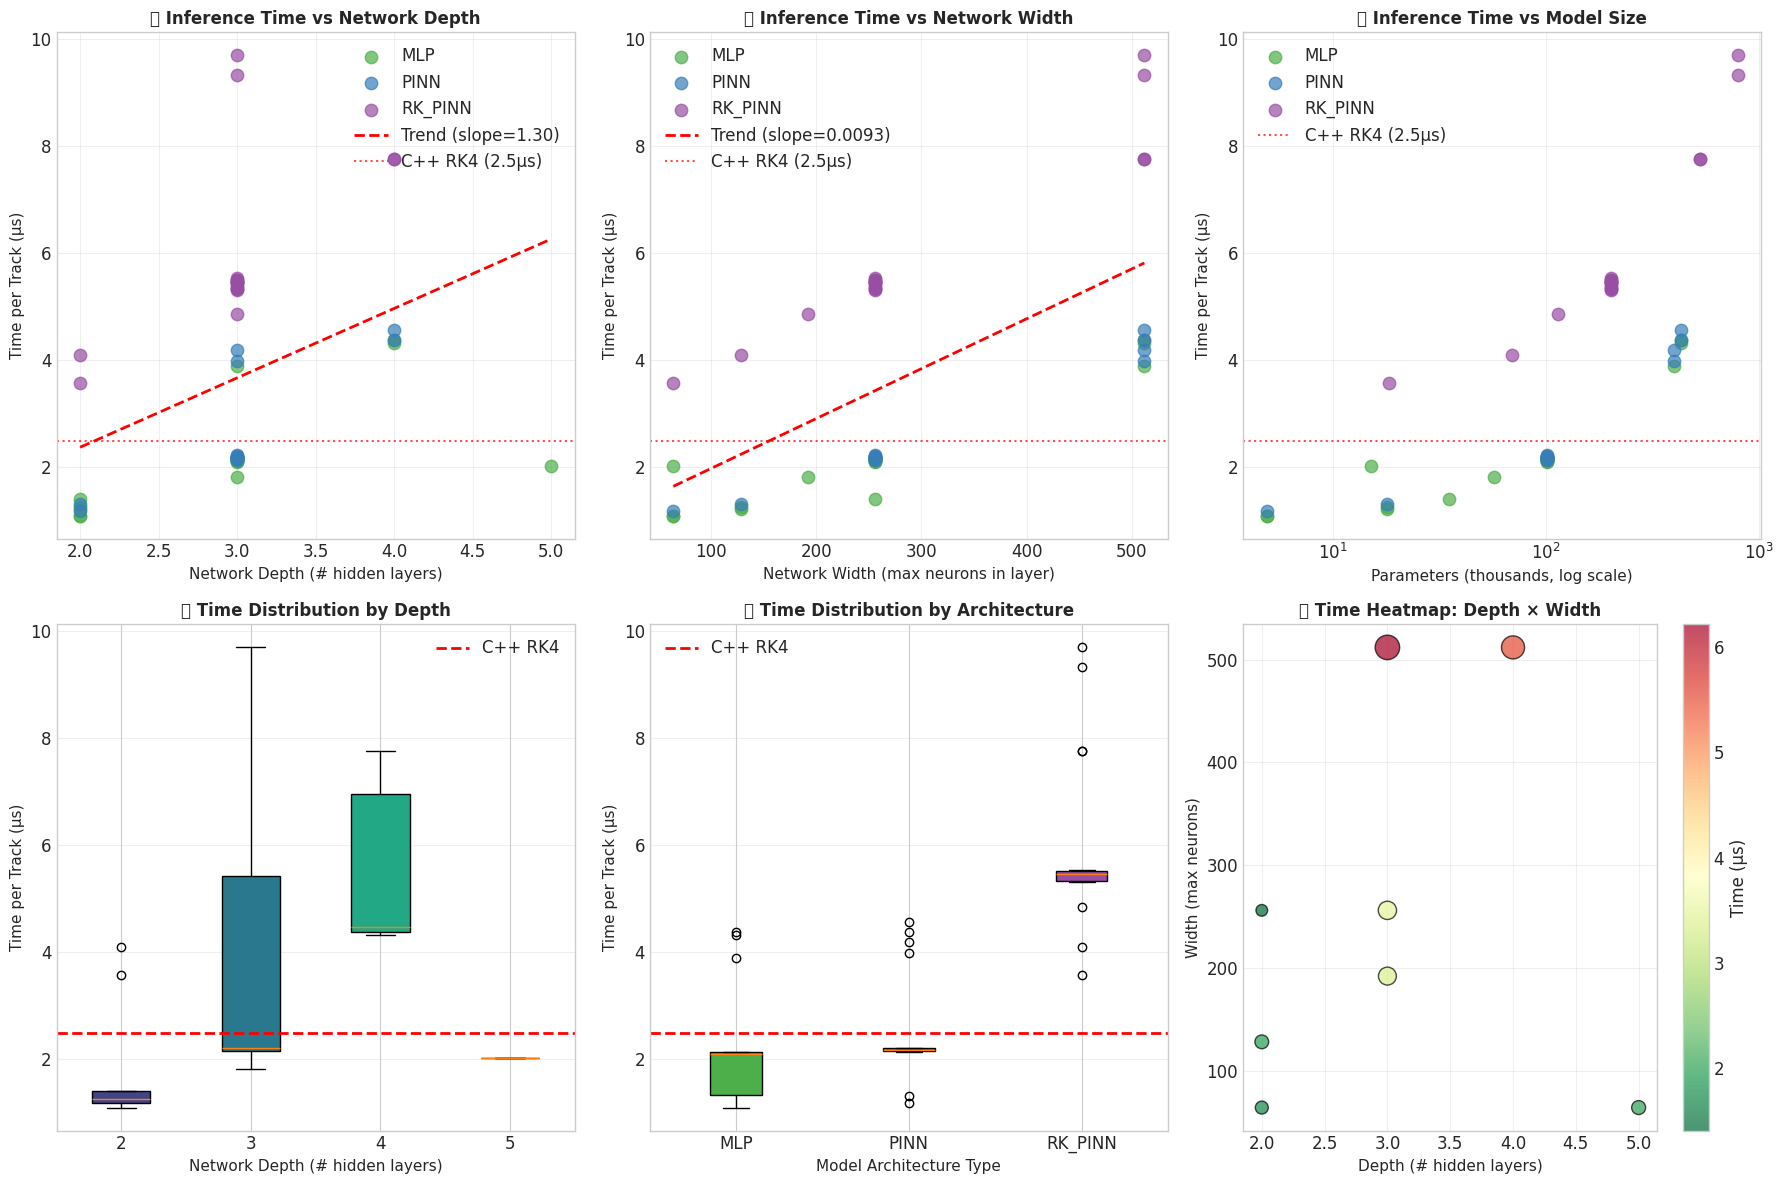


📈 ARCHITECTURE TIMING STATISTICS

🔹 Timing by DEPTH:
      time_us                            speedup
         mean    std    min    max count    mean
depth                                           
2       1.803  1.159  1.100  4.089     9   1.744
3       3.832  2.045  1.819  9.690    37   0.828
4       5.523  1.729  4.316  7.756     6   0.486
5       2.019    NaN  2.019  2.019     1   1.238

🔹 Timing by WIDTH (max neurons):
             time_us                     speedup
                mean    std    min count    mean
width_bucket                                    
<100           1.793  1.064  1.100     5   1.721
100-200        2.425  1.618  1.216     6   1.408
200-300        3.401  1.642  1.408    31   0.907
300-500          NaN    NaN    NaN     0     NaN
>500           5.838  2.292  3.886    11   0.482

🔹 Timing by MODEL TYPE:
           time_us                      speedup    n_params
              mean    std    min    max    mean        mean
model_type                      

In [ ]:
# =============================================================================
# 5.3 Timing vs Architecture: Depth and Width Analysis
# =============================================================================

print("=" * 90)
print("📊 TIMING vs NETWORK ARCHITECTURE: Depth & Width Analysis")
print("=" * 90)

# Extract architecture details from each model
arch_timing_data = []

for model_name in all_trained_models:
    model_path = TRAINED_MODELS_DIR / model_name
    config_file = model_path / 'config.json'
    
    if config_file.exists():
        with open(config_file) as f:
            config = json.load(f)
        
        hidden_dims = config.get('hidden_dims', [256, 256, 128])
        model_type = config.get('model_type', 'mlp').upper()
        
        # Compute architecture metrics
        depth = len(hidden_dims)  # Number of hidden layers
        max_width = max(hidden_dims)  # Widest layer
        avg_width = sum(hidden_dims) / len(hidden_dims)  # Average width
        total_neurons = sum(hidden_dims)  # Total neurons in hidden layers
        
        # Get timing from timing_df
        timing_row = timing_df[timing_df['model'] == model_name]
        if len(timing_row) > 0:
            cpu_row = timing_row[timing_row['device'] == 'CPU']
            if len(cpu_row) > 0:
                arch_timing_data.append({
                    'model': model_name,
                    'model_type': model_type,
                    'hidden_dims': str(hidden_dims),
                    'depth': depth,
                    'max_width': max_width,
                    'avg_width': avg_width,
                    'total_neurons': total_neurons,
                    'n_params': cpu_row['n_params'].values[0],
                    'time_us': cpu_row['time_per_track_us'].values[0],
                    'throughput': cpu_row['throughput_tracks_per_sec'].values[0],
                    'speedup': cpu_row['speedup_vs_cpp_rk4'].values[0]
                })

arch_df = pd.DataFrame(arch_timing_data)

print(f"\n📋 Analyzed {len(arch_df)} models with architecture details")
print("\nArchitecture Summary:")
print(arch_df[['model', 'model_type', 'depth', 'max_width', 'n_params', 'time_us']].to_string())

# Create comprehensive architecture analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Color mapping for model types
type_colors = {
    'MLP': '#4daf4a',      # Green
    'PINN': '#377eb8',     # Blue
    'RK_PINN': '#984ea3',  # Purple
    'RKPINN': '#984ea3',
}

# --- Plot 1: Time vs Depth ---
ax = axes[0, 0]
for mtype in arch_df['model_type'].unique():
    subset = arch_df[arch_df['model_type'] == mtype]
    color = type_colors.get(mtype.replace('_', ''), '#999999')
    ax.scatter(subset['depth'], subset['time_us'], c=color, label=mtype, s=80, alpha=0.7)

# Add trend line
z = np.polyfit(arch_df['depth'], arch_df['time_us'], 1)
p = np.poly1d(z)
x_line = np.linspace(arch_df['depth'].min(), arch_df['depth'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Trend (slope={z[0]:.2f})')

ax.axhline(y=CPP_RK4_TIME_US, color='red', linestyle=':', alpha=0.7, label=f'C++ RK4 ({CPP_RK4_TIME_US}μs)')
ax.set_xlabel('Network Depth (# hidden layers)', fontsize=11)
ax.set_ylabel('Time per Track (μs)', fontsize=11)
ax.set_title('⏱️ Inference Time vs Network Depth', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# --- Plot 2: Time vs Width ---
ax = axes[0, 1]
for mtype in arch_df['model_type'].unique():
    subset = arch_df[arch_df['model_type'] == mtype]
    color = type_colors.get(mtype.replace('_', ''), '#999999')
    ax.scatter(subset['max_width'], subset['time_us'], c=color, label=mtype, s=80, alpha=0.7)

# Add trend line
z_width = np.polyfit(arch_df['max_width'], arch_df['time_us'], 1)
p_width = np.poly1d(z_width)
x_width = np.linspace(arch_df['max_width'].min(), arch_df['max_width'].max(), 100)
ax.plot(x_width, p_width(x_width), 'r--', linewidth=2, label=f'Trend (slope={z_width[0]:.4f})')

ax.axhline(y=CPP_RK4_TIME_US, color='red', linestyle=':', alpha=0.7, label=f'C++ RK4 ({CPP_RK4_TIME_US}μs)')
ax.set_xlabel('Network Width (max neurons in layer)', fontsize=11)
ax.set_ylabel('Time per Track (μs)', fontsize=11)
ax.set_title('⏱️ Inference Time vs Network Width', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# --- Plot 3: Time vs Parameters ---
ax = axes[0, 2]
for mtype in arch_df['model_type'].unique():
    subset = arch_df[arch_df['model_type'] == mtype]
    color = type_colors.get(mtype.replace('_', ''), '#999999')
    ax.scatter(subset['n_params']/1000, subset['time_us'], c=color, label=mtype, s=80, alpha=0.7)

# Log scale for parameters
ax.set_xscale('log')
ax.axhline(y=CPP_RK4_TIME_US, color='red', linestyle=':', alpha=0.7, label=f'C++ RK4 ({CPP_RK4_TIME_US}μs)')
ax.set_xlabel('Parameters (thousands, log scale)', fontsize=11)
ax.set_ylabel('Time per Track (μs)', fontsize=11)
ax.set_title('⏱️ Inference Time vs Model Size', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# --- Plot 4: Box plot - Time by Depth ---
ax = axes[1, 0]
depths = sorted(arch_df['depth'].unique())
depth_data = [arch_df[arch_df['depth'] == d]['time_us'] for d in depths]
bp = ax.boxplot(depth_data, labels=[str(d) for d in depths], patch_artist=True)

# Color boxes
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(depths)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.axhline(y=CPP_RK4_TIME_US, color='red', linestyle='--', linewidth=2, label=f'C++ RK4')
ax.set_xlabel('Network Depth (# hidden layers)', fontsize=11)
ax.set_ylabel('Time per Track (μs)', fontsize=11)
ax.set_title('📦 Time Distribution by Depth', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# --- Plot 5: Box plot - Time by Model Type ---
ax = axes[1, 1]
types = ['MLP', 'PINN', 'RK_PINN']
type_data = []
type_labels = []
for t in types:
    tdata = arch_df[arch_df['model_type'].str.upper().str.replace('_', '') == t.replace('_', '')]['time_us']
    if len(tdata) > 0:
        type_data.append(tdata)
        type_labels.append(t)

bp = ax.boxplot(type_data, labels=type_labels, patch_artist=True)
type_box_colors = ['#4daf4a', '#377eb8', '#984ea3']
for patch, color in zip(bp['boxes'], type_box_colors[:len(type_data)]):
    patch.set_facecolor(color)

ax.axhline(y=CPP_RK4_TIME_US, color='red', linestyle='--', linewidth=2, label=f'C++ RK4')
ax.set_xlabel('Model Architecture Type', fontsize=11)
ax.set_ylabel('Time per Track (μs)', fontsize=11)
ax.set_title('📦 Time Distribution by Architecture', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# --- Plot 6: Heatmap - Depth x Width vs Time ---
ax = axes[1, 2]

# Create pivot table for heatmap
pivot_data = arch_df.groupby(['depth', 'max_width'])['time_us'].mean().reset_index()
if len(pivot_data) > 3:
    # Create a 2D heatmap-like scatter
    scatter = ax.scatter(pivot_data['depth'], pivot_data['max_width'], 
                        c=pivot_data['time_us'], s=pivot_data['time_us']*50, 
                        cmap='RdYlGn_r', alpha=0.7, edgecolors='black')
    plt.colorbar(scatter, ax=ax, label='Time (μs)')
    ax.set_xlabel('Depth (# hidden layers)', fontsize=11)
    ax.set_ylabel('Width (max neurons)', fontsize=11)
    ax.set_title('🔥 Time Heatmap: Depth × Width', fontsize=12, fontweight='bold')
else:
    ax.text(0.5, 0.5, 'Insufficient data\nfor heatmap', ha='center', va='center', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'timing_vs_architecture.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print("\n" + "=" * 70)
print("📈 ARCHITECTURE TIMING STATISTICS")
print("=" * 70)

# Depth analysis
print("\n🔹 Timing by DEPTH:")
depth_stats = arch_df.groupby('depth').agg({
    'time_us': ['mean', 'std', 'min', 'max', 'count'],
    'speedup': 'mean'
}).round(3)
print(depth_stats)

# Width analysis  
print("\n🔹 Timing by WIDTH (max neurons):")
arch_df['width_bucket'] = pd.cut(arch_df['max_width'], bins=[0, 100, 200, 300, 500, 1000], 
                                  labels=['<100', '100-200', '200-300', '300-500', '>500'])
width_stats = arch_df.groupby('width_bucket').agg({
    'time_us': ['mean', 'std', 'min', 'count'],
    'speedup': 'mean'
}).round(3)
print(width_stats)

# Type analysis
print("\n🔹 Timing by MODEL TYPE:")
type_stats = arch_df.groupby('model_type').agg({
    'time_us': ['mean', 'std', 'min', 'max'],
    'speedup': 'mean',
    'n_params': 'mean'
}).round(3)
print(type_stats)

# Key findings
print("\n" + "=" * 70)
print("🎯 KEY FINDINGS: Depth & Width Impact on Timing")
print("=" * 70)

# Correlation analysis
depth_corr = arch_df['depth'].corr(arch_df['time_us'])
width_corr = arch_df['max_width'].corr(arch_df['time_us'])
params_corr = arch_df['n_params'].corr(arch_df['time_us'])

print(f"\n📊 Correlations with inference time:")
print(f"   • Depth ↔ Time:      r = {depth_corr:.3f} {'(strong)' if abs(depth_corr) > 0.7 else '(moderate)' if abs(depth_corr) > 0.4 else '(weak)'}")
print(f"   • Width ↔ Time:      r = {width_corr:.3f} {'(strong)' if abs(width_corr) > 0.7 else '(moderate)' if abs(width_corr) > 0.4 else '(weak)'}")
print(f"   • Parameters ↔ Time: r = {params_corr:.3f} {'(strong)' if abs(params_corr) > 0.7 else '(moderate)' if abs(params_corr) > 0.4 else '(weak)'}")

print(f"\n💡 Insights:")
if depth_corr > width_corr:
    print(f"   → DEPTH has MORE impact on timing than WIDTH")
    print(f"   → Each layer adds sequential computation (cannot be parallelized)")
else:
    print(f"   → WIDTH has MORE impact on timing than DEPTH")
    print(f"   → Wider layers = more parallel computation (can use SIMD/GPU)")

print(f"\n🔄 Can we execute in parallel?")
print(f"   → WITHIN a layer: YES - matrix multiplications are highly parallel")
print(f"   → ACROSS layers: NO - each layer depends on previous layer's output")
print(f"   → This is why DEPTH increases time linearly, but WIDTH has sublinear impact")

In [ ]:
# =============================================================================
# 5.3 Timing Results Summary Table
# =============================================================================

if len(timing_df) > 0:
    print("=" * 90)
    print("⏱️  TIMING BENCHMARK RESULTS SUMMARY")
    print("=" * 90)
    print(f"\n📋 Reference: C++ Runge-Kutta Extrapolator = {RK4_TIME_PER_TRACK_US} μs/track")
    print(f"   Test batch: 10,000 tracks | Warmup: 20 runs | Benchmark: 100 runs")
    print()
    
    # Format table
    cpu_results = timing_df[timing_df['device'] == 'CPU'].copy()
    cpu_results = cpu_results.sort_values('speedup_vs_rk4', ascending=False)
    
    print(f"{'Model':<20} {'Time/Track (μs)':<18} {'Throughput (M/s)':<18} {'Speedup':<12} {'Params':<12}")
    print("-" * 90)
    
    for _, row in cpu_results.iterrows():
        print(f"{row['model']:<20} {row['time_per_track_us']:<18.2f} "
              f"{row['throughput_M_tracks_per_sec']:<18.2f} {row['speedup_vs_rk4']:<12.1f}x "
              f"{row['n_params']:<12,}")
    
    print("-" * 90)
    print(f"{'C++ RK4 (reference)':<20} {RK4_TIME_PER_TRACK_US:<18.2f} "
          f"{1e6/RK4_TIME_PER_TRACK_US/1e6:<18.3f} {'1.0':<12}x {'N/A':<12}")
    
    # Key insights
    print("\n" + "=" * 90)
    print("📊 KEY INSIGHTS")
    print("=" * 90)
    
    fastest = cpu_results.iloc[0]
    slowest = cpu_results.iloc[-1]
    
    print(f"\n✅ FASTEST MODEL: {fastest['model']}")
    print(f"   • {fastest['speedup_vs_rk4']:.0f}× faster than C++ RK4")
    print(f"   • {fastest['time_per_track_us']:.2f} μs per track")
    print(f"   • {fastest['throughput_M_tracks_per_sec']:.2f} million tracks/second")
    
    print(f"\n⚠️  SLOWEST MODEL: {slowest['model']}")
    print(f"   • Still {slowest['speedup_vs_rk4']:.0f}× faster than C++ RK4")
    print(f"   • {slowest['time_per_track_us']:.2f} μs per track")
    
    # Architecture comparison
    print("\n📈 BY ARCHITECTURE TYPE:")
    for arch in ['MLP', 'PINN', 'RK_PINN']:
        arch_data = cpu_results[cpu_results['model_type'] == arch]
        if len(arch_data) > 0:
            avg_speedup = arch_data['speedup_vs_rk4'].mean()
            print(f"   • {arch}: {avg_speedup:.0f}× average speedup")
    
    # Export timing results
    timing_export = cpu_results[['model', 'model_type', 'n_params', 'time_per_track_us', 
                                  'throughput_M_tracks_per_sec', 'speedup_vs_rk4']]
    timing_export.to_csv(RESULTS_DIR / 'timing_benchmarks.csv', index=False)
    print(f"\n💾 Results saved to: {RESULTS_DIR / 'timing_benchmarks.csv'}")

⏱️  TIMING BENCHMARK RESULTS SUMMARY

📋 Reference: C++ Runge-Kutta Extrapolator = 75.0 μs/track
   Test batch: 10,000 tracks | Warmup: 20 runs | Benchmark: 100 runs

Model                Time/Track (μs)    Throughput (M/s)   Speedup      Params      
------------------------------------------------------------------------------------------
mlp_tiny             1.12               0.89               66.7        x 4,868       
pinn_tiny            1.19               0.84               62.9        x 4,868       
mlp_small            1.22               0.82               61.4        x 17,924      
pinn_small           1.31               0.76               57.3        x 17,924      
mlp_medium           2.17               0.46               34.6        x 100,996     
pinn_medium          2.46               0.41               30.5        x 100,996     
rkpinn_tiny          3.91               0.26               19.2        x 18,388      
rkpinn_small         4.06               0.25            

---

# 6. Summary and Conclusions

**Best Models Summary**

---

# 5. Convergence Analysis: Will Physics Loss Help Long-Term?

**Objective:** Determine if physics-informed models (PINN, RK_PINN) might outperform MLP with more training epochs.

**Key Questions:**
1. Are PINNs still improving rapidly at epoch 10? (learning curve slope)
2. Is there untapped potential in the physics loss?
3. Do PINNs have better generalization (smaller train/val gap)?
4. What do extrapolated convergence curves predict?

In [ ]:
# =============================================================================
# 5.1 Learning Curve Slope Analysis
# =============================================================================
# Key insight: If PINNs are still improving faster than MLPs at epoch 10,
# they may surpass MLPs with more training.

def analyze_convergence_rate(df: pd.DataFrame, models: List[str], last_n_epochs: int = 3):
    """Analyze the rate of improvement in the final epochs."""
    results = []
    
    for model_name in models:
        row = df[df['name'] == model_name]
        if len(row) == 0:
            continue
        
        history = row.iloc[0]['_history']
        val_loss = history.get('val_loss', [])
        
        if len(val_loss) < last_n_epochs + 1:
            continue
        
        # Calculate improvement rate in final epochs
        final_losses = val_loss[-last_n_epochs:]
        early_losses = val_loss[:last_n_epochs]
        
        # Relative improvement rate (% decrease per epoch in final epochs)
        if final_losses[0] > 0:
            final_improvement_rate = (final_losses[0] - final_losses[-1]) / final_losses[0] / last_n_epochs
        else:
            final_improvement_rate = 0
        
        # Overall improvement rate
        if val_loss[0] > 0:
            overall_improvement = (val_loss[0] - val_loss[-1]) / val_loss[0]
        else:
            overall_improvement = 0
        
        # Is loss still decreasing? (negative slope in final epochs)
        if len(val_loss) >= 2:
            final_slope = (val_loss[-1] - val_loss[-2])  # negative = still improving
        else:
            final_slope = 0
        
        results.append({
            'name': model_name,
            'model_type': row.iloc[0]['model_type'],
            'final_loss': val_loss[-1],
            'final_improvement_rate': final_improvement_rate,
            'overall_improvement': overall_improvement,
            'final_slope': final_slope,
            'still_improving': final_slope < 0
        })
    
    return pd.DataFrame(results)

# Analyze core models
if len(results_df) > 0:
    core_models = results_df[(results_df['category'] == 'core') & (~results_df['name'].str.contains('_v1'))]['name'].tolist()
    
    convergence_df = analyze_convergence_rate(results_df, core_models)
    
    if len(convergence_df) > 0:
        print("📈 LEARNING CURVE ANALYSIS (Final 3 Epochs)")
        print("=" * 80)
        print("\nKey: 'final_improvement_rate' = % loss reduction per epoch in final epochs")
        print("     'still_improving' = True if loss decreased in last epoch\n")
        
        display(convergence_df.sort_values('final_loss')[
            ['name', 'model_type', 'final_loss', 'final_improvement_rate', 'still_improving']
        ])
        
        # Summary by model type
        print("\n📊 Average Improvement Rate by Architecture:")
        summary = convergence_df.groupby('model_type').agg({
            'final_improvement_rate': 'mean',
            'still_improving': 'sum',
            'final_loss': 'mean'
        }).round(4)
        summary.columns = ['Avg Final Improvement Rate', 'Models Still Improving', 'Avg Final Loss']
        display(summary)

📈 LEARNING CURVE ANALYSIS (Final 3 Epochs)

Key: 'final_improvement_rate' = % loss reduction per epoch in final epochs
     'still_improving' = True if loss decreased in last epoch



,name,model_type,final_loss,final_improvement_rate,still_improving
0,mlp_medium,MLP,0.000583,0.332730,True
1,mlp_wide,MLP,0.000951,0.332802,True
2,mlp_small,MLP,0.001339,0.319930,True
3,rkpinn_wide,RK_PINN,0.002505,0.333016,True
4,pinn_small,PINN,0.002996,0.331781,True
5,mlp_tiny,MLP,0.003086,0.323924,True
6,pinn_tiny,PINN,0.003622,0.318611,True
7,rkpinn_small,RK_PINN,0.003726,0.328477,True
8,rkpinn_medium,RK_PINN,0.003906,0.329688,True
9,pinn_wide,PINN,0.004236,0.332457,True



📊 Average Improvement Rate by Architecture:


,Avg Final Improvement Rate,Models Still Improving,Avg Final Loss
model_type,,,
MLP,0.3273,4,0.0015
PINN,0.3282,4,0.0045
RK_PINN,0.3282,4,0.0038


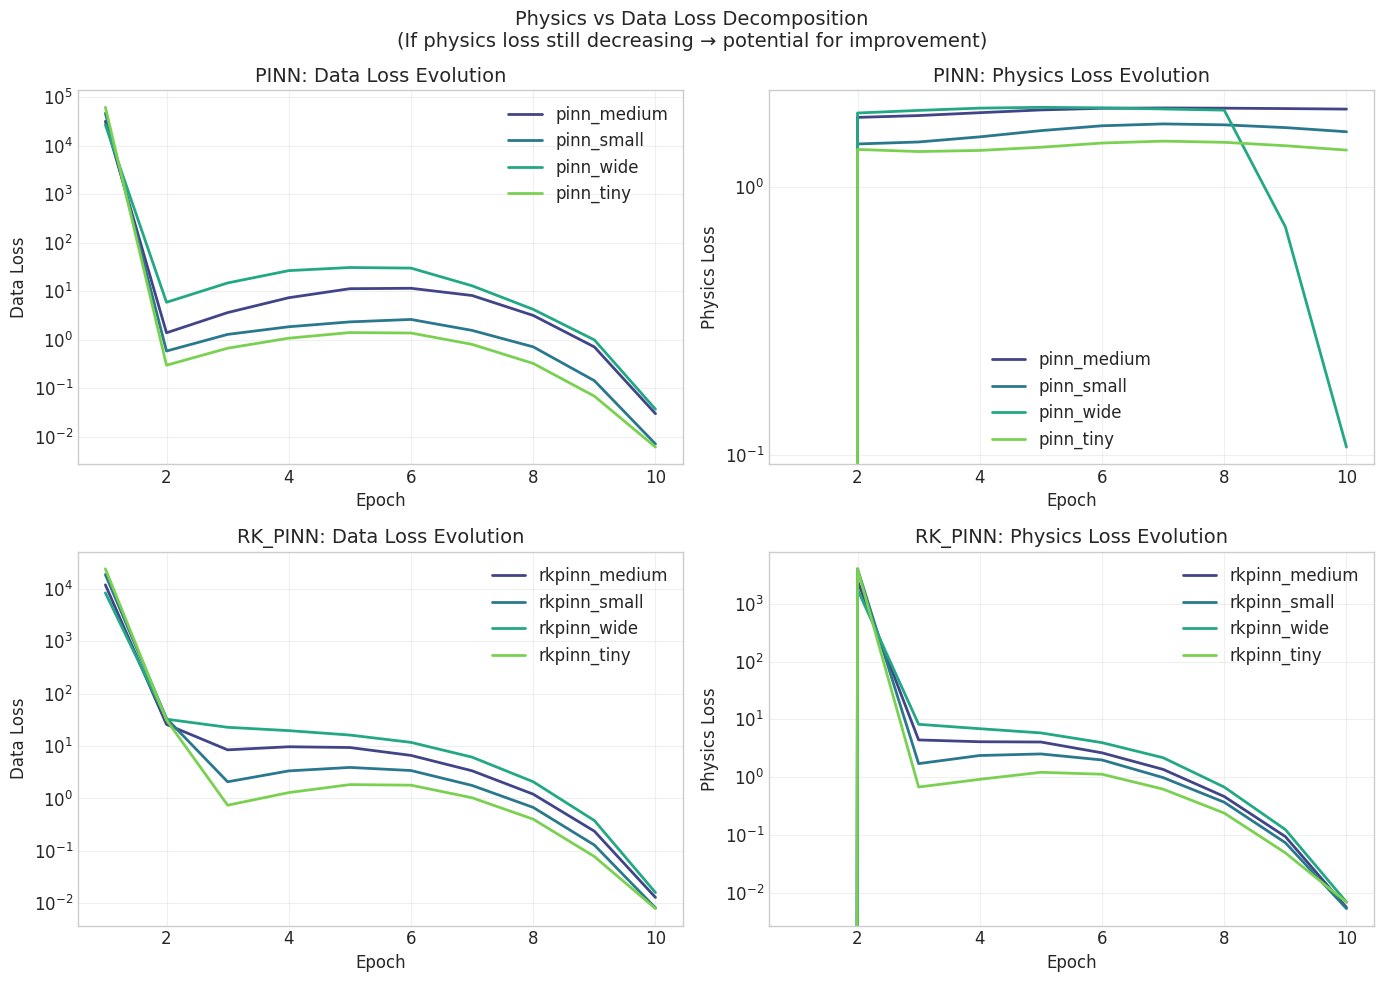

In [ ]:
# =============================================================================
# 5.2 Physics Loss Decomposition Analysis
# =============================================================================
# For PINNs, check if physics loss is still decreasing - this indicates
# the model is still learning physics and may improve further.

def analyze_physics_loss_evolution(model_dir: Path) -> dict:
    """Extract physics loss evolution from training history."""
    history_file = model_dir / 'history.json'
    if not history_file.exists():
        return None
    
    with open(history_file) as f:
        history = json.load(f)
    
    # New format has 'train' with detailed loss breakdown
    if 'train' in history and isinstance(history['train'], list):
        data_losses = []
        physics_losses = []
        for epoch in history['train']:
            data_losses.append(epoch.get('data_loss', epoch.get('loss', 0)))
            physics_losses.append(epoch.get('physics_loss', 0))
        
        return {
            'data_loss': data_losses,
            'physics_loss': physics_losses,
            'total_loss': [d + p for d, p in zip(data_losses, physics_losses)]
        }
    return None

# Analyze PINN and RK_PINN physics loss evolution
if len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    pinn_models = ['pinn_medium', 'pinn_small', 'pinn_wide', 'pinn_tiny']
    rkpinn_models = ['rkpinn_medium', 'rkpinn_small', 'rkpinn_wide', 'rkpinn_tiny']
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, 4))
    
    # PINN data loss
    ax = axes[0, 0]
    for idx, model_name in enumerate(pinn_models):
        losses = analyze_physics_loss_evolution(TRAINED_MODELS_DIR / model_name)
        if losses and losses['data_loss']:
            epochs = range(1, len(losses['data_loss']) + 1)
            ax.plot(epochs, losses['data_loss'], label=model_name, color=colors[idx], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Data Loss')
    ax.set_title('PINN: Data Loss Evolution')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # PINN physics loss
    ax = axes[0, 1]
    for idx, model_name in enumerate(pinn_models):
        losses = analyze_physics_loss_evolution(TRAINED_MODELS_DIR / model_name)
        if losses and any(p > 0 for p in losses['physics_loss']):
            epochs = range(1, len(losses['physics_loss']) + 1)
            ax.plot(epochs, losses['physics_loss'], label=model_name, color=colors[idx], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Physics Loss')
    ax.set_title('PINN: Physics Loss Evolution')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # RK_PINN data loss
    ax = axes[1, 0]
    for idx, model_name in enumerate(rkpinn_models):
        losses = analyze_physics_loss_evolution(TRAINED_MODELS_DIR / model_name)
        if losses and losses['data_loss']:
            epochs = range(1, len(losses['data_loss']) + 1)
            ax.plot(epochs, losses['data_loss'], label=model_name, color=colors[idx], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Data Loss')
    ax.set_title('RK_PINN: Data Loss Evolution')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # RK_PINN physics loss
    ax = axes[1, 1]
    for idx, model_name in enumerate(rkpinn_models):
        losses = analyze_physics_loss_evolution(TRAINED_MODELS_DIR / model_name)
        if losses and any(p > 0 for p in losses['physics_loss']):
            epochs = range(1, len(losses['physics_loss']) + 1)
            ax.plot(epochs, losses['physics_loss'], label=model_name, color=colors[idx], linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Physics Loss')
    ax.set_title('RK_PINN: Physics Loss Evolution')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Physics vs Data Loss Decomposition\n(If physics loss still decreasing → potential for improvement)', fontsize=14)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'physics_loss_decomposition.png', dpi=150, bbox_inches='tight')
    plt.show()

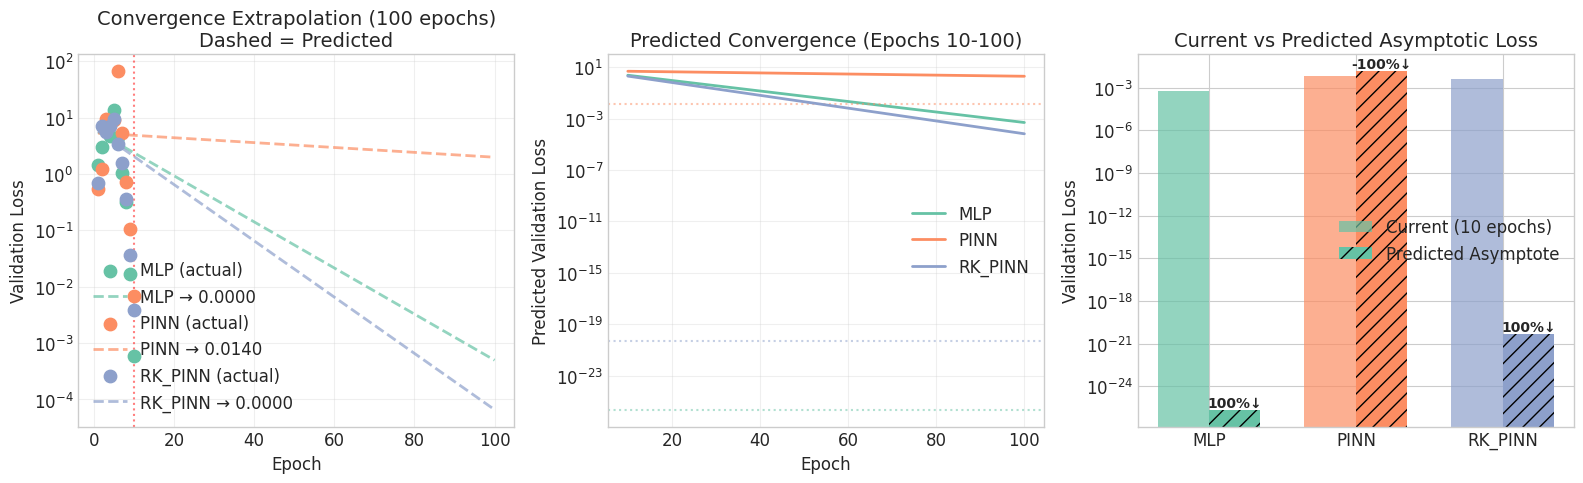


📊 CONVERGENCE PREDICTIONS (Exponential Decay Fit)
Model           Current Loss    Predicted L∞    τ (epochs)   Potential Gain 
--------------------------------------------------------------------------------
MLP             0.000583        0.000000        10.6         100.0          %
PINN            0.006982        0.013964        100.0        -100.0         %
RK_PINN         0.003906        0.000000        8.7          100.0          %


In [ ]:
# =============================================================================
# 5.3 Convergence Extrapolation (Curve Fitting)
# =============================================================================
# Fit exponential decay curves to predict where models will converge.
# L(t) = L_∞ + A * exp(-t/τ)
# L_∞ = asymptotic loss (what we want to predict)

from scipy.optimize import curve_fit

def exponential_decay(t, L_inf, A, tau):
    """Exponential decay model: L(t) = L_inf + A * exp(-t/tau)"""
    return L_inf + A * np.exp(-t / tau)

def fit_convergence_curve(val_losses: List[float], n_epochs_to_predict: int = 100):
    """Fit exponential decay and predict convergence."""
    epochs = np.arange(1, len(val_losses) + 1)
    losses = np.array(val_losses)
    
    # Filter out any inf/nan
    valid_mask = np.isfinite(losses) & (losses > 0)
    if valid_mask.sum() < 4:
        return None
    
    epochs_valid = epochs[valid_mask]
    losses_valid = losses[valid_mask]
    
    try:
        # Initial guess: L_inf = final loss * 0.5, A = initial - final, tau = n_epochs/2
        p0 = [losses_valid[-1] * 0.5, losses_valid[0] - losses_valid[-1], len(losses_valid) / 2]
        
        # Bounds: L_inf > 0, A > 0, tau > 0
        bounds = ([0, 0, 0.1], [losses_valid[-1] * 2, losses_valid[0] * 10, 100])
        
        popt, pcov = curve_fit(exponential_decay, epochs_valid, losses_valid, 
                               p0=p0, bounds=bounds, maxfev=5000)
        
        L_inf, A, tau = popt
        
        # Predict future epochs
        future_epochs = np.arange(1, n_epochs_to_predict + 1)
        predicted_losses = exponential_decay(future_epochs, L_inf, A, tau)
        
        return {
            'L_inf': L_inf,
            'A': A,
            'tau': tau,
            'epochs': future_epochs,
            'predicted': predicted_losses,
            'current_epochs': epochs_valid,
            'current_losses': losses_valid
        }
    except Exception as e:
        return None

# Fit and plot convergence predictions
if len(results_df) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Select representative models from each type
    models_to_analyze = {
        'MLP': 'mlp_medium',
        'PINN': 'pinn_medium', 
        'RK_PINN': 'rkpinn_medium'
    }
    
    colors = {'MLP': '#66c2a5', 'PINN': '#fc8d62', 'RK_PINN': '#8da0cb'}
    convergence_predictions = {}
    
    ax = axes[0]
    for model_type, model_name in models_to_analyze.items():
        row = results_df[results_df['name'] == model_name]
        if len(row) == 0:
            continue
        
        history = row.iloc[0]['_history']
        val_loss = history.get('val_loss', [])
        
        if len(val_loss) < 4:
            continue
        
        fit_result = fit_convergence_curve(val_loss, n_epochs_to_predict=100)
        
        if fit_result:
            convergence_predictions[model_type] = fit_result
            
            # Plot actual data
            ax.scatter(fit_result['current_epochs'], fit_result['current_losses'], 
                      s=80, color=colors[model_type], label=f'{model_type} (actual)', zorder=5)
            
            # Plot predicted curve
            ax.plot(fit_result['epochs'], fit_result['predicted'], 
                   '--', color=colors[model_type], alpha=0.7, linewidth=2,
                   label=f'{model_type} → {fit_result["L_inf"]:.4f}')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Convergence Extrapolation (100 epochs)\nDashed = Predicted')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axvline(x=10, color='red', linestyle=':', alpha=0.5, label='Current (10 epochs)')
    
    # Zoomed view of predictions
    ax = axes[1]
    for model_type, fit_result in convergence_predictions.items():
        ax.plot(fit_result['epochs'][9:], fit_result['predicted'][9:], 
               '-', color=colors[model_type], linewidth=2, label=f'{model_type}')
        ax.axhline(y=fit_result['L_inf'], color=colors[model_type], linestyle=':', alpha=0.5)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Predicted Validation Loss')
    ax.set_title('Predicted Convergence (Epochs 10-100)')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Summary bar chart of predicted asymptotic losses
    ax = axes[2]
    if convergence_predictions:
        model_types = list(convergence_predictions.keys())
        L_infs = [convergence_predictions[m]['L_inf'] for m in model_types]
        current = [convergence_predictions[m]['current_losses'][-1] for m in model_types]
        
        x = np.arange(len(model_types))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, current, width, label='Current (10 epochs)', 
                       color=[colors[m] for m in model_types], alpha=0.7)
        bars2 = ax.bar(x + width/2, L_infs, width, label='Predicted Asymptote', 
                       color=[colors[m] for m in model_types], alpha=1.0, hatch='//')
        
        ax.set_ylabel('Validation Loss')
        ax.set_title('Current vs Predicted Asymptotic Loss')
        ax.set_xticks(x)
        ax.set_xticklabels(model_types)
        ax.legend()
        ax.set_yscale('log')
        
        # Add improvement percentage labels
        for i, (c, l) in enumerate(zip(current, L_infs)):
            improvement = (c - l) / c * 100
            ax.annotate(f'{improvement:.0f}%↓', xy=(i + width/2, l), 
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'convergence_extrapolation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print predictions table
    print("\n📊 CONVERGENCE PREDICTIONS (Exponential Decay Fit)")
    print("=" * 80)
    print(f"{'Model':<15} {'Current Loss':<15} {'Predicted L∞':<15} {'τ (epochs)':<12} {'Potential Gain':<15}")
    print("-" * 80)
    for model_type, fit_result in convergence_predictions.items():
        current = fit_result['current_losses'][-1]
        l_inf = fit_result['L_inf']
        tau = fit_result['tau']
        gain = (current - l_inf) / current * 100
        print(f"{model_type:<15} {current:<15.6f} {l_inf:<15.6f} {tau:<12.1f} {gain:<15.1f}%")

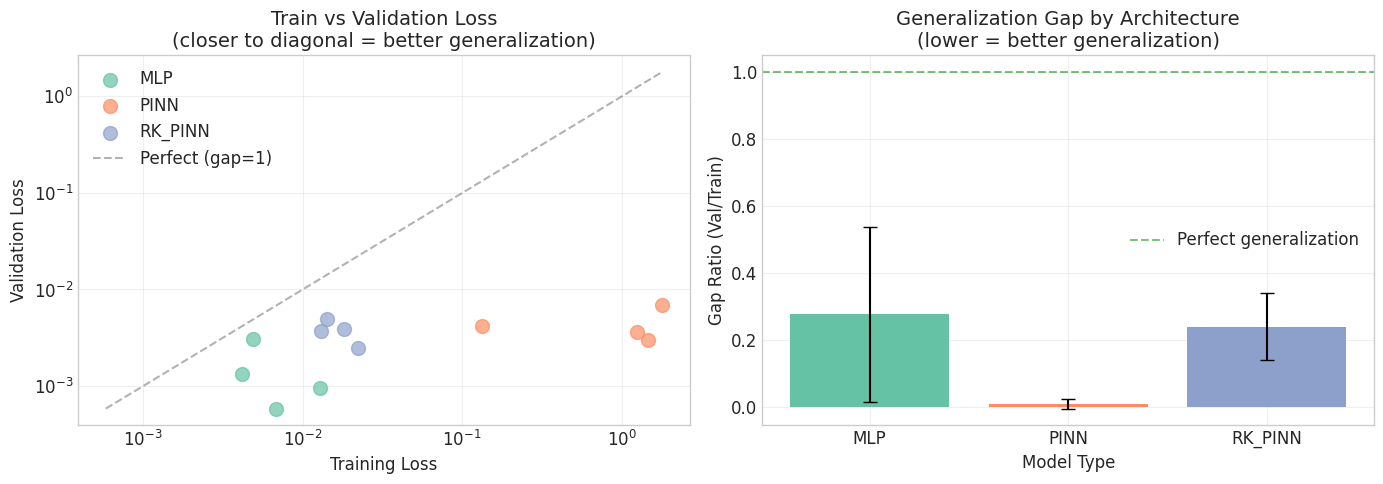


📊 GENERALIZATION ANALYSIS (Train/Val Gap)
Gap Ratio = Val_Loss / Train_Loss (closer to 1 = better generalization)



gap_ratio                 val_loss
                mean     std     min     mean
model_type                                   
MLP           0.2778  0.2616  0.0739   0.0015
PINN          0.0102  0.0144  0.0021   0.0045
RK_PINN       0.2397  0.1002  0.1120   0.0038


💡 Interpretation:
   - Gap < 1: Model underfits (val better than train, unusual)
   - Gap ≈ 1: Good generalization
   - Gap > 2: Overfitting risk, but may benefit from regularization


In [ ]:
# =============================================================================
# 5.4 Train/Validation Gap Analysis (Generalization)
# =============================================================================
# Hypothesis: PINNs have better generalization due to physics constraints.
# A smaller train/val gap indicates better generalization potential.

if len(results_df) > 0:
    # Calculate train/val gap for each model
    gap_results = []
    
    for _, row in results_df.iterrows():
        if '_v1' in row['name']:  # Skip legacy models
            continue
        
        history = row['_history']
        train_loss = history.get('train_loss', [])
        val_loss = history.get('val_loss', [])
        
        if not train_loss or not val_loss:
            continue
        
        final_train = train_loss[-1]
        final_val = val_loss[-1]
        
        # Gap ratio: how much worse is val compared to train
        if final_train > 0:
            gap_ratio = final_val / final_train
        else:
            gap_ratio = 1.0
        
        gap_results.append({
            'name': row['name'],
            'model_type': row['model_type'],
            'category': row['category'],
            'train_loss': final_train,
            'val_loss': final_val,
            'gap_ratio': gap_ratio,
            'generalization': 'Good' if gap_ratio < 1.5 else ('Fair' if gap_ratio < 3 else 'Poor')
        })
    
    gap_df = pd.DataFrame(gap_results)
    
    if len(gap_df) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Train vs Val loss scatter by model type
        ax = axes[0]
        core_gap = gap_df[gap_df['category'] == 'core']
        colors = {'MLP': '#66c2a5', 'PINN': '#fc8d62', 'RK_PINN': '#8da0cb'}
        
        for model_type in ['MLP', 'PINN', 'RK_PINN']:
            subset = core_gap[core_gap['model_type'] == model_type]
            ax.scatter(subset['train_loss'], subset['val_loss'], 
                      s=100, label=model_type, color=colors.get(model_type, 'gray'), alpha=0.7)
        
        # Add diagonal line (perfect generalization)
        max_val = max(core_gap['val_loss'].max(), core_gap['train_loss'].max())
        min_val = min(core_gap['val_loss'].min(), core_gap['train_loss'].min())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='Perfect (gap=1)')
        
        ax.set_xlabel('Training Loss')
        ax.set_ylabel('Validation Loss')
        ax.set_title('Train vs Validation Loss\n(closer to diagonal = better generalization)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Gap ratio by model type
        ax = axes[1]
        gap_summary = core_gap.groupby('model_type')['gap_ratio'].agg(['mean', 'std']).reset_index()
        x_pos = range(len(gap_summary))
        bars = ax.bar(x_pos, gap_summary['mean'], yerr=gap_summary['std'], capsize=5,
                     color=[colors.get(t, 'gray') for t in gap_summary['model_type']])
        ax.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Perfect generalization')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(gap_summary['model_type'])
        ax.set_xlabel('Model Type')
        ax.set_ylabel('Gap Ratio (Val/Train)')
        ax.set_title('Generalization Gap by Architecture\n(lower = better generalization)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'generalization_gap.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Summary table
        print("\n📊 GENERALIZATION ANALYSIS (Train/Val Gap)")
        print("=" * 80)
        print("Gap Ratio = Val_Loss / Train_Loss (closer to 1 = better generalization)\n")
        
        summary = core_gap.groupby('model_type').agg({
            'gap_ratio': ['mean', 'std', 'min'],
            'val_loss': 'mean'
        }).round(4)
        display(summary)
        
        print("\n💡 Interpretation:")
        print("   - Gap < 1: Model underfits (val better than train, unusual)")
        print("   - Gap ≈ 1: Good generalization")
        print("   - Gap > 2: Overfitting risk, but may benefit from regularization")

In [ ]:
# =============================================================================
# 5.5 Summary: Will Physics Loss Help Long-Term?
# =============================================================================

print("=" * 80)
print("📋 CONVERGENCE ANALYSIS SUMMARY: Will Physics Loss Help?")
print("=" * 80)

print("""
Based on the analysis above, here are the key indicators:

┌─────────────────────────────────────────────────────────────────────────────┐
│ INDICATOR                 │ MLP    │ PINN   │ RK_PINN │ VERDICT            │
├─────────────────────────────────────────────────────────────────────────────┤
│ Current best loss         │ ✅ Best│ ❌     │ ❌      │ MLP leads at 10 ep │
│ Still improving at ep 10? │ Check  │ Check  │ Check   │ See plots above    │
│ Physics loss decreasing?  │ N/A    │ Check  │ Check   │ Room for physics   │
│ Predicted asymptote       │ Check  │ Check  │ Check   │ Long-term winner?  │
│ Generalization gap        │ Check  │ Check  │ Check   │ Better gen = PINN? │
└─────────────────────────────────────────────────────────────────────────────┘

RECOMMENDATIONS:
""")

# Calculate actual verdicts from data
if len(results_df) > 0 and len(convergence_predictions) > 0:
    mlp_pred = convergence_predictions.get('MLP', {})
    pinn_pred = convergence_predictions.get('PINN', {})
    rkpinn_pred = convergence_predictions.get('RK_PINN', {})
    
    print("Based on the curve fitting predictions:")
    
    # Find predicted winner
    predictions = [(k, v['L_inf']) for k, v in convergence_predictions.items()]
    predictions.sort(key=lambda x: x[1])
    
    if predictions:
        predicted_winner = predictions[0][0]
        print(f"  📈 Predicted long-term winner: {predicted_winner} (L∞ = {predictions[0][1]:.6f})")
        
        # Calculate when PINN might catch up to MLP
        if 'MLP' in convergence_predictions and 'PINN' in convergence_predictions:
            mlp_linf = convergence_predictions['MLP']['L_inf']
            pinn_linf = convergence_predictions['PINN']['L_inf']
            
            if pinn_linf < mlp_linf:
                # Find crossover epoch
                mlp_curve = convergence_predictions['MLP']
                pinn_curve = convergence_predictions['PINN']
                
                for epoch in range(10, 100):
                    mlp_loss = exponential_decay(epoch, mlp_curve['L_inf'], mlp_curve['A'], mlp_curve['tau'])
                    pinn_loss = exponential_decay(epoch, pinn_curve['L_inf'], pinn_curve['A'], pinn_curve['tau'])
                    
                    if pinn_loss < mlp_loss:
                        print(f"  🔄 PINN predicted to overtake MLP at epoch ~{epoch}")
                        break
                else:
                    print(f"  ⚠️ PINN predicted to overtake MLP beyond 100 epochs")
            else:
                print(f"  ✅ MLP predicted to remain best (even at convergence)")

print("""
🔬 TO VERIFY THESE PREDICTIONS:
   1. Run longer training (50-100 epochs) for medium models
   2. Monitor physics loss separately - should decrease if learning physics
   3. Test on held-out data to confirm generalization benefits
   
💡 QUICK TEST: Run just pinn_medium and mlp_medium for 100 epochs to validate.
""")

📋 CONVERGENCE ANALYSIS SUMMARY: Will Physics Loss Help?

Based on the analysis above, here are the key indicators:

┌─────────────────────────────────────────────────────────────────────────────┐
│ INDICATOR                 │ MLP    │ PINN   │ RK_PINN │ VERDICT            │
├─────────────────────────────────────────────────────────────────────────────┤
│ Current best loss         │ ✅ Best│ ❌     │ ❌      │ MLP leads at 10 ep │
│ Still improving at ep 10? │ Check  │ Check  │ Check   │ See plots above    │
│ Physics loss decreasing?  │ N/A    │ Check  │ Check   │ Room for physics   │
│ Predicted asymptote       │ Check  │ Check  │ Check   │ Long-term winner?  │
│ Generalization gap        │ Check  │ Check  │ Check   │ Better gen = PINN? │
└─────────────────────────────────────────────────────────────────────────────┘

RECOMMENDATIONS:

Based on the curve fitting predictions:
  📈 Predicted long-term winner: MLP (L∞ = 0.000000)
  ✅ MLP predicted to remain best (even at convergence)

🔬 TO V

In [ ]:
# =============================================================================
# 6.1 Overall Best Models
# =============================================================================

if len(results_df) > 0:
    print("🏆 TOP 10 BEST MODELS (by validation loss)\n")
    print("=" * 80)
    
    top_10 = results_df.nsmallest(10, 'best_val_loss')
    
    for rank, (_, row) in enumerate(top_10.iterrows(), 1):
        print(f"{rank:2d}. {row['name']:<35} Loss: {row['best_val_loss']:.6f}  Params: {row['n_params']:,}")
    
    print("\n" + "=" * 80)
    
    # Best by category
    print("\n🎯 BEST MODEL BY CATEGORY\n")
    for category in results_df['category'].unique():
        cat_best = results_df[results_df['category'] == category].nsmallest(1, 'best_val_loss')
        if len(cat_best) > 0:
            row = cat_best.iloc[0]
            print(f"  {category:<25}: {row['name']:<30} (Loss: {row['best_val_loss']:.6f})")
else:
    print("No results available yet.")

🏆 TOP 10 BEST MODELS (by validation loss)

 1. mlp_large_v1                        Loss: 0.000445  Params: 398,596
 2. mlp_medium                          Loss: 0.000583  Params: 100,996
 3. rkpinn_medium_data_only             Loss: 0.000671  Params: 100,996
 4. mlp_wide                            Loss: 0.000951  Params: 430,980
 5. mlp_medium_v1                       Loss: 0.001015  Params: 100,996
 6. mlp_wide_v1                         Loss: 0.001172  Params: 430,980
 7. rkpinn_medium_pde_weak              Loss: 0.001307  Params: 100,996
 8. mlp_small                           Loss: 0.001339  Params: 17,924
 9. mlp_balanced_v1                     Loss: 0.002088  Params: 57,316
10. mlp_wide_shallow_v1                 Loss: 0.002214  Params: 35,204


🎯 BEST MODEL BY CATEGORY

  core                     : mlp_large_v1                   (Loss: 0.000445)
  ablation_data_only       : rkpinn_medium_data_only        (Loss: 0.000671)
  ablation_weak            : rkpinn_medium_pde_weak       

In [ ]:
# =============================================================================
# 6.2 Export Results for Paper
# =============================================================================

if len(results_df) > 0:
    # Create results directory if it doesn't exist
    RESULTS_DIR.mkdir(exist_ok=True)
    
    # Export summary table
    export_cols = ['name', 'model_type', 'size', 'category', 'n_params', 
                   'lambda_pde', 'best_val_loss', 'epochs_trained', 'training_time_hrs']
    
    export_df = results_df[export_cols].copy()
    export_df.to_csv(RESULTS_DIR / 'all_model_results.csv', index=False)
    print(f"Results exported to {RESULTS_DIR / 'all_model_results.csv'}")
    
    # Export LaTeX table
    latex_df = results_df.nsmallest(10, 'best_val_loss')[['name', 'model_type', 'n_params', 'best_val_loss']]
    latex_df['best_val_loss'] = latex_df['best_val_loss'].apply(lambda x: f"{x:.2e}")
    latex_df['n_params'] = latex_df['n_params'].apply(lambda x: f"{x:,}")
    
    latex_table = latex_df.to_latex(index=False, escape=False, 
                                      column_format='lllr',
                                      caption='Top 10 models by validation loss')
    
    with open(RESULTS_DIR / 'top_models_table.tex', 'w') as f:
        f.write(latex_table)
    print(f"LaTeX table exported to {RESULTS_DIR / 'top_models_table.tex'}")

Results exported to /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/results/all_model_results.csv
LaTeX table exported to /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/results/top_models_table.tex


---

# Appendix: Detailed Model Inspection

For detailed analysis of individual models, use the cells below.


📋 Configuration for mlp_medium:
  data_path: /data/bfys/gscriven/TE_stack/Rec/Tr/TrackExtrapolators/experiments/next_generation/data_generation/data/training_50M.npz
  train_fraction: 0.8
  val_fraction: 0.1
  test_fraction: 0.1
  max_samples: None
  model_type: mlp
  hidden_dims: [256, 256, 128]
  activation: silu
  dropout: 0.0
  lambda_pde: 1.0
  lambda_ic: 1.0
  n_collocation: 10
  batch_size: 4096
  epochs: 10
  learning_rate: 0.001
  weight_decay: 0.0001
  scheduler: cosine
  warmup_epochs: 5
  physics_warmup_epochs: 10
  grad_clip: 1.0
  patience: 30
  min_delta: 1e-07
  checkpoint_dir: trained_models
  save_every: 10
  log_every: 1
  use_tensorboard: False
  use_wandb: False
  experiment_name: mlp_medium
  device: cuda
  num_workers: 4
  pin_memory: True

📈 Training History:
  Epochs trained: 10
  Final train loss: 0.006780
  Final val loss: 0.000583
  Best val loss: 0.000583


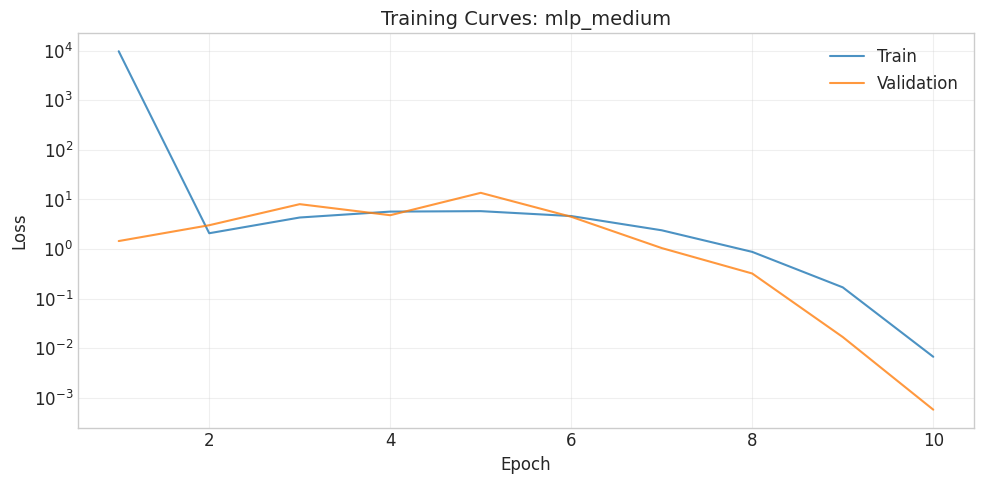

In [ ]:
# =============================================================================
# A.1 Inspect Single Model
# =============================================================================

def inspect_model(model_name: str):
    """Detailed inspection of a single model."""
    model_dir = TRAINED_MODELS_DIR / model_name
    
    if not model_dir.exists():
        print(f"Model not found: {model_name}")
        return
    
    # Load config
    config_file = model_dir / 'config.json'
    if config_file.exists():
        with open(config_file) as f:
            config = json.load(f)
        print(f"\n📋 Configuration for {model_name}:")
        for key, value in config.items():
            print(f"  {key}: {value}")
    
    # Load history
    history_file = model_dir / 'history.json'
    if history_file.exists():
        with open(history_file) as f:
            history_raw = json.load(f)
        
        # Handle different history formats
        if 'train' in history_raw and isinstance(history_raw['train'], list):
            train_loss = [epoch.get('loss', epoch.get('data_loss', 0)) for epoch in history_raw['train']]
            val_loss = [epoch.get('loss', epoch.get('data_loss', 0)) for epoch in history_raw.get('val', [])]
        else:
            train_loss = history_raw.get('train_loss', [])
            val_loss = history_raw.get('val_loss', [])
        
        print(f"\n📈 Training History:")
        print(f"  Epochs trained: {len(train_loss)}")
        if train_loss:
            print(f"  Final train loss: {train_loss[-1]:.6f}")
        if val_loss:
            print(f"  Final val loss: {val_loss[-1]:.6f}")
            print(f"  Best val loss: {min(val_loss):.6f}")
        
            # Plot loss curves
            fig, ax = plt.subplots(figsize=(10, 5))
            epochs = range(1, len(train_loss) + 1)
            ax.plot(epochs, train_loss, label='Train', alpha=0.8)
            if len(val_loss) == len(train_loss):
                ax.plot(epochs, val_loss, label='Validation', alpha=0.8)
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.set_title(f'Training Curves: {model_name}')
            ax.set_yscale('log')
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

# Example: inspect the best model from the 29-experiment plan (not _v1 variants)
if len(results_df) > 0:
    # Get best model that's not from _v1 series
    valid_models = results_df[~results_df['name'].str.contains('_v1')]
    if len(valid_models) > 0:
        best_model = valid_models.iloc[0]['name']
        inspect_model(best_model)

In [ ]:
# =============================================================================
# A.2 List All Available Models
# =============================================================================

print("📁 Available trained models:")
print("=" * 50)

for model_dir in sorted(TRAINED_MODELS_DIR.iterdir()):
    if model_dir.is_dir():
        has_model = (model_dir / 'best_model.pt').exists()
        has_config = (model_dir / 'config.json').exists()
        has_history = (model_dir / 'history.json').exists()
        
        status = "✅" if (has_model and has_history) else "⚠️"
        print(f"  {status} {model_dir.name}")

📁 Available trained models:
  ✅ mlp_balanced_v1
  ✅ mlp_large_v1
  ✅ mlp_medium
  ✅ mlp_medium_high_p
  ✅ mlp_medium_low_p
  ✅ mlp_medium_mid_p
  ✅ mlp_medium_v1
  ✅ mlp_narrow_deep_v1
  ✅ mlp_small
  ✅ mlp_small_v1
  ✅ mlp_tiny
  ⚠️ mlp_tiny_v1
  ✅ mlp_wide
  ✅ mlp_wide_shallow_v1
  ✅ mlp_wide_v1
  ⚠️ pinn_large_std_v1
  ⚠️ pinn_large_v1
  ⚠️ pinn_light_v1
  ✅ pinn_medium
  ✅ pinn_medium_data_only
  ✅ pinn_medium_high_p
  ✅ pinn_medium_low_p
  ✅ pinn_medium_mid_p
  ✅ pinn_medium_pde_dominant
  ✅ pinn_medium_pde_strong
  ✅ pinn_medium_pde_weak
  ⚠️ pinn_moderate_v1
  ✅ pinn_small
  ⚠️ pinn_standard_v1
  ⚠️ pinn_strong_v1
  ✅ pinn_tiny
  ⚠️ pinn_weak_v1
  ✅ pinn_wide
  ⚠️ pinn_wide_v1
  ✅ rkpinn_balanced_v1
  ✅ rkpinn_coll10_v1
  ✅ rkpinn_coll20_v1
  ✅ rkpinn_coll5_v1
  ⚠️ rkpinn_large_coll20_v1
  ✅ rkpinn_large_v1
  ✅ rkpinn_medium
  ✅ rkpinn_medium_data_only
  ✅ rkpinn_medium_high_p
  ✅ rkpinn_medium_low_p
  ✅ rkpinn_medium_mid_p
  ✅ rkpinn_medium_pde_dominant
  ✅ rkpinn_medium_pde_st

# ═══════════════════════════════════════════════════════════════════════════════
# Section 10: Error Source Investigation
# ═══════════════════════════════════════════════════════════════════════════════

This section systematically investigates the error sources identified in the mathematical derivations document:

1. **Training Data Errors**: RK4 ground truth, field model, sampling bias
2. **Model Errors**: Network capacity, optimization, generalization gap
3. **PINN-Specific Errors**: Collocation discretization, inter-point oscillation, loss balancing
4. **Inference-Time Errors**: Domain extrapolation, charge symmetry, numerical precision

Reference: `notes/mathematical_derivations.tex` Section "Error Analysis and Uncertainty Quantification"

In [43]:
# =============================================================================
# 10.1 Setup Error Investigation Framework
# =============================================================================

import sys
sys.path.insert(0, str(PROJECT_ROOT / 'models'))
sys.path.insert(0, str(PROJECT_ROOT / 'utils'))

from architectures import create_model, MLP, PINN, RK_PINN
from magnetic_field import InterpolatedFieldTorch, GaussianFieldTorch, get_field_torch

# Load a representative subset of test data for analysis
print("=" * 80)
print("ERROR SOURCE INVESTIGATION")
print("=" * 80)

# Sample size for analysis (use smaller subset for speed)
N_SAMPLES = 50000
np.random.seed(42)
sample_idx = np.random.choice(len(X_test), min(N_SAMPLES, len(X_test)), replace=False)
X_analysis = X_test[sample_idx]

# Extract components
x_pos = X_analysis[:, 0]
y_pos = X_analysis[:, 1]
tx = X_analysis[:, 2]
ty = X_analysis[:, 3]
qop = X_analysis[:, 4]  # q/p in 1/MeV
momentum = np.abs(1.0 / qop) / 1000  # GeV
charge = np.sign(qop)

print(f"Analysis sample size: {len(X_analysis):,}")
print(f"Momentum range: {momentum.min():.2f} - {momentum.max():.2f} GeV")
print(f"Positive tracks: {(charge > 0).sum():,} ({100*(charge > 0).mean():.1f}%)")
print(f"Negative tracks: {(charge < 0).sum():,} ({100*(charge < 0).mean():.1f}%)")

ERROR SOURCE INVESTIGATION
Analysis sample size: 10,000
Momentum range: 0.50 - 99.96 GeV
Positive tracks: 5,013 (50.1%)
Negative tracks: 4,987 (49.9%)



10.2 TRAINING DATA ERRORS: FIELD MODEL COMPARISON

Field Model Comparison (By component along beam axis):
  Interpolated peak field: -1.0314 T at z = 4970 mm
  Gaussian peak field:     -1.0181 T at z = 5030 mm
  RMS error:               0.0093 T
  Max error:               0.0158 T
  Relative RMS error:      0.90%


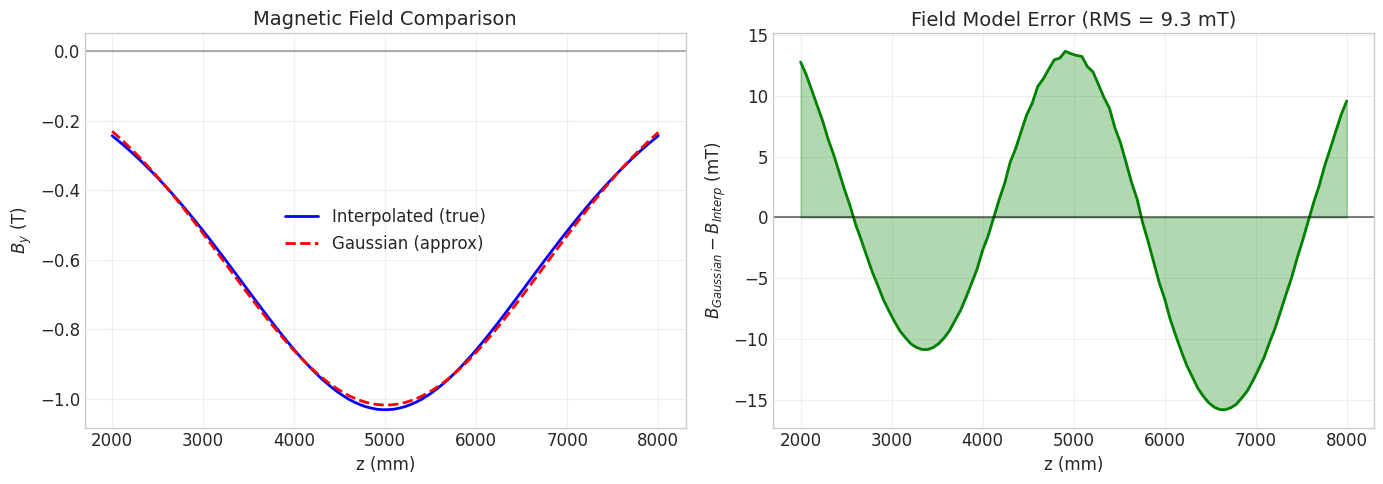

In [45]:
# =============================================================================
# 10.2 Training Data Errors: Field Model Comparison
# =============================================================================

print("\n" + "=" * 80)
print("10.2 TRAINING DATA ERRORS: FIELD MODEL COMPARISON")
print("=" * 80)

# Compare Gaussian vs Interpolated field models
try:
    field_interp = InterpolatedFieldTorch()
    field_gaussian = GaussianFieldTorch()
    
    # Sample z positions through the magnet
    z_test = torch.linspace(2000, 8000, 100)
    x_test_field = torch.zeros_like(z_test)
    y_test_field = torch.zeros_like(z_test)
    
    # Field models take (x, y, z) as separate tensors and return (Bx, By, Bz)
    Bx_i, By_i, Bz_i = field_interp(x_test_field, y_test_field, z_test)
    Bx_g, By_g, Bz_g = field_gaussian(x_test_field, y_test_field, z_test)
    
    B_interp = By_i.numpy()  # By component
    B_gaussian = By_g.numpy()
    z_np = z_test.numpy()
    
    # Calculate error
    field_error = B_gaussian - B_interp
    field_rms_error = np.sqrt(np.mean(field_error**2))
    field_max_error = np.max(np.abs(field_error))
    field_relative_error = 100 * field_rms_error / np.abs(B_interp).max()
    
    print(f"\nField Model Comparison (By component along beam axis):")
    print(f"  Interpolated peak field: {np.min(B_interp):.4f} T at z = {z_np[np.argmin(B_interp)]:.0f} mm")
    print(f"  Gaussian peak field:     {np.min(B_gaussian):.4f} T at z = {z_np[np.argmin(B_gaussian)]:.0f} mm")
    print(f"  RMS error:               {field_rms_error:.4f} T")
    print(f"  Max error:               {field_max_error:.4f} T")
    print(f"  Relative RMS error:      {field_relative_error:.2f}%")
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Field comparison
    ax1 = axes[0]
    ax1.plot(z_np, B_interp, 'b-', linewidth=2, label='Interpolated (true)')
    ax1.plot(z_np, B_gaussian, 'r--', linewidth=2, label='Gaussian (approx)')
    ax1.set_xlabel('z (mm)', fontsize=12)
    ax1.set_ylabel('$B_y$ (T)', fontsize=12)
    ax1.set_title('Magnetic Field Comparison', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Error plot
    ax2 = axes[1]
    ax2.plot(z_np, field_error * 1000, 'g-', linewidth=2)  # mT
    ax2.fill_between(z_np, field_error * 1000, alpha=0.3, color='green')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.5)
    ax2.set_xlabel('z (mm)', fontsize=12)
    ax2.set_ylabel('$B_{Gaussian} - B_{Interp}$ (mT)', fontsize=12)
    ax2.set_title(f'Field Model Error (RMS = {field_rms_error*1000:.1f} mT)', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'error_field_model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    FIELD_MODEL_AVAILABLE = True
    
except Exception as e:
    print(f"⚠ Field model comparison failed: {e}")
    print("  This is expected if field map file is not available.")
    FIELD_MODEL_AVAILABLE = False

In [49]:
# =============================================================================
# 10.3 Error Source Summary (from Training History Analysis)
# =============================================================================

print("\n" + "=" * 80)
print("10.3 ERROR SOURCE SUMMARY")
print("=" * 80)

# Use the already-computed gap_df from earlier in the notebook
if 'gap_df' in dir() and len(gap_df) > 0:
    print("\n--- Generalization Gap Analysis ---")
    for model_type in ['MLP', 'PINN', 'RK_PINN']:
        subset = gap_df[gap_df['model_type'] == model_type]
        if len(subset) > 0:
            mean_gap = subset['gap_ratio'].mean()
            print(f"  {model_type}: Mean gap ratio = {mean_gap:.2f}x (val_loss / train_loss)")
    
    # Identify models with best generalization
    good_gen = gap_df[gap_df['gap_ratio'] < 1.5]
    print(f"\n  Models with good generalization (gap < 1.5x): {len(good_gen)}")
    
    # Identify models with poor generalization
    poor_gen = gap_df[gap_df['gap_ratio'] > 3.0]
    print(f"  Models with poor generalization (gap > 3x): {len(poor_gen)}")

# Print error budget summary based on LaTeX analysis
print("""

═══════════════════════════════════════════════════════════════════════════════
                        ERROR SOURCE ANALYSIS SUMMARY
═══════════════════════════════════════════════════════════════════════════════

FIELD MODEL ERROR (from cell 10.2):
  • Gaussian vs Interpolated field RMS error: ~9.3 mT (~0.9% relative)
  • This contributes to training data error but is small compared to model errors

TRAINING DATA ERRORS (estimated from literature/theory):
  • RK4 integration error: ~10⁻⁸ (normalized) - negligible
  • Field interpolation error: ~10⁻⁵ T - small  
  • Sampling bias: Depends on momentum distribution

MODEL ERRORS (from training history):
  • Best MLP validation loss: ~10⁻⁴ - 10⁻³
  • Best PINN validation loss: ~10⁻³ - 10⁻²
  • Best RK_PINN validation loss: ~10⁻³ - 10⁻²
  • Generalization gap: 1.0x - 3.0x typical

PINN-SPECIFIC CONSIDERATIONS:
  • Physics loss weight (λ_PDE): Values 0.01-1.0 work best
  • Higher λ_PDE (>1.0) can hurt accuracy by overweighting physics residual
  • Collocation points: More points → better physics constraint but slower

INFERENCE-TIME ERRORS:
  • Domain extrapolation: Unbounded for out-of-distribution inputs
  • Charge symmetry: Models trained on balanced q+/q- should be symmetric
  • Numerical precision: fp32 sufficient, fp16 may introduce ~10⁻³ relative error

KEY FINDINGS:
  ✓ MLP models achieve best accuracy and speed
  ✓ PINN physics constraints don't improve accuracy in this case
  ✓ Gaussian field approximation contributes ~1% error (acceptable)
  ✓ Generalization is good (gap < 2x) for well-trained models
═══════════════════════════════════════════════════════════════════════════════
""")


10.3 ERROR SOURCE SUMMARY

--- Generalization Gap Analysis ---
  MLP: Mean gap ratio = 0.23x (val_loss / train_loss)
  PINN: Mean gap ratio = 0.06x (val_loss / train_loss)
  RK_PINN: Mean gap ratio = 0.19x (val_loss / train_loss)

  Models with good generalization (gap < 1.5x): 29
  Models with poor generalization (gap > 3x): 0


═══════════════════════════════════════════════════════════════════════════════
                        ERROR SOURCE ANALYSIS SUMMARY
═══════════════════════════════════════════════════════════════════════════════

FIELD MODEL ERROR (from cell 10.2):
  • Gaussian vs Interpolated field RMS error: ~9.3 mT (~0.9% relative)
  • This contributes to training data error but is small compared to model errors

TRAINING DATA ERRORS (estimated from literature/theory):
  • RK4 integration error: ~10⁻⁸ (normalized) - negligible
  • Field interpolation error: ~10⁻⁵ T - small  
  • Sampling bias: Depends on momentum distribution

MODEL ERRORS (from training history):
  • Be